# Cell-Cell interaction Analysis using NCEM  
### Spatial pancreas  
Annotation of dissociated data from npod by Rebecca Melton - Gaulton's lab 

### Pre-requisites

In [3]:
import seaborn as sns
import pandas as pd
import numpy as np

import scanpy as sc
import squidpy as sq
import ncem as nc

import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=80, facecolor="white")

In [5]:
nc.__version__

'0.1.5'

### Load data

In [7]:
folder = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'
adata_10 = sc.read(folder+'adata_fov_10_npod_annotation_wo_B+Schwann.h5ad')
adata_12 = sc.read(folder+'adata_fov_12_npod_annotation_wo_B+Schwann.h5ad')
adata_10,adata_12

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


(AnnData object with n_obs × n_vars = 4423 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'CellTypes_max_colors', 'cell_type_coarse_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_fov'
     varm: 'PCs'
     layers: 'cou

In [8]:
adata_10.obs['CellTypes_max'].cat.categories

Index(['Acinar_basal', 'Acinar_highEnz', 'Acinar_sigdiff', 'Acinar_signal',
       'Activated_Stellate', 'Alpha', 'Beta', 'Delta', 'Ductal', 'Endothelial',
       'LymphEndo', 'MUC5b_Ductal', 'Macrophage', 'Mast', 'Quiescent_Stellate',
       'Tcells'],
      dtype='object')

In [9]:
adata_12.obs['CellTypes_max'].cat.categories

Index(['Acinar_basal', 'Acinar_highEnz', 'Acinar_sigdiff', 'Acinar_signal',
       'Activated_Stellate', 'Alpha', 'Beta', 'Delta', 'Ductal', 'Endothelial',
       'LymphEndo', 'MUC5b_Ductal', 'Macrophage', 'Mast', 'Quiescent_Stellate',
       'Tcells'],
      dtype='object')

In [10]:
CellTypes_max_10 = adata_10.obs['CellTypes_max']
CellTypes_max_12 = adata_12.obs['CellTypes_max']

new_order = ['Acinar_basal', 'Acinar_highEnz', 'Acinar_signal', 'Acinar_sigdiff', 'Ductal', 'MUC5b_Ductal',
             'Beta', 'Alpha', 'Delta', 'Activated_Stellate', 'Quiescent_Stellate', 'Endothelial', 'LymphEndo', 
             'Macrophage', 'Tcells', 'Mast']

adata_10.obs['CellTypes_max'] = pd.Categorical(CellTypes_max_10, categories=new_order, ordered=True)
adata_12.obs['CellTypes_max'] = pd.Categorical(CellTypes_max_12, categories=new_order, ordered=True)


In [11]:
print(adata_10.obs['CellTypes_max'].cat.categories)

Index(['Acinar_basal', 'Acinar_highEnz', 'Acinar_signal', 'Acinar_sigdiff',
       'Ductal', 'MUC5b_Ductal', 'Beta', 'Alpha', 'Delta',
       'Activated_Stellate', 'Quiescent_Stellate', 'Endothelial', 'LymphEndo',
       'Macrophage', 'Tcells', 'Mast'],
      dtype='object')


In [12]:
markers={
    'Acinar_basal':['REG1A'],
    #'Acinar_highEnz':['CTRB1'],#PRSS1
    'Acinar_signal':['SOD2'],
    'Acinar_sigdiff':['MT1X'],
    #'Ductal': ['CFTR'],
    #'MUC5b_Ductal':['MUC5B'],
    'Beta': ['INS'],
    'Alpha':['GCG'],
    'Delta': ['SST'],
    'Activated_Stellate':['COL6A3'],
    'Quiescent_Stellate': ['SPARCL1'],
    #'Endothelial':['PLVAP'],
    #'LymphEndo':['FLT4'],
    'Macrophage':['C1QB'],
    'Tcells': ['CD2'],
    #'Schwann': ['CDH19'],
    'Mast':['KIT'],
    'Bcells':['CD53']    
}

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


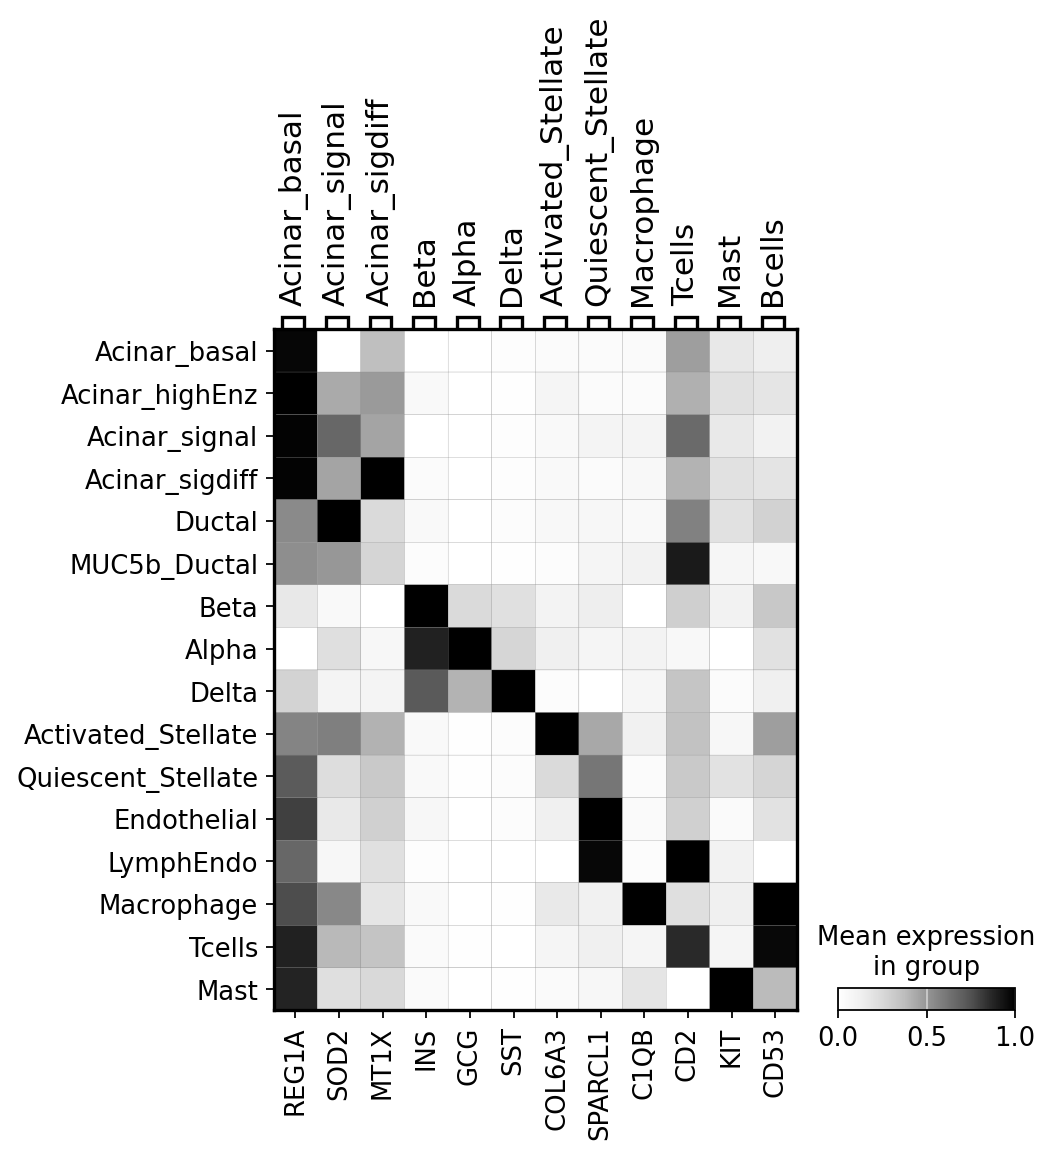

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


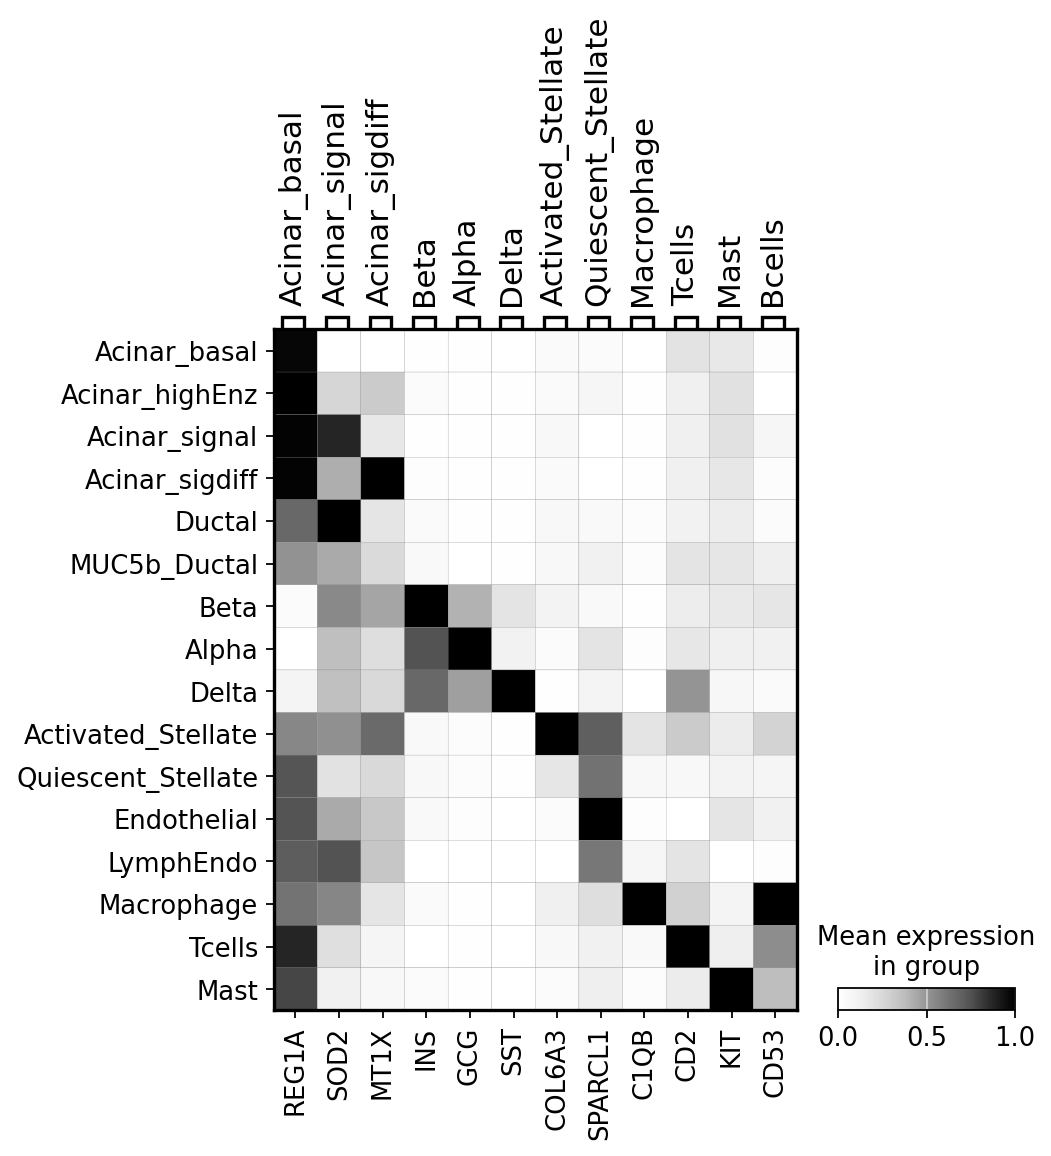

In [13]:
sc.pl.matrixplot(adata_10, markers,groupby='CellTypes_max', cmap='Greys',standard_scale='var')
sc.pl.matrixplot(adata_12, markers,groupby='CellTypes_max', cmap='Greys',standard_scale='var')

### Data Exploration

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is 

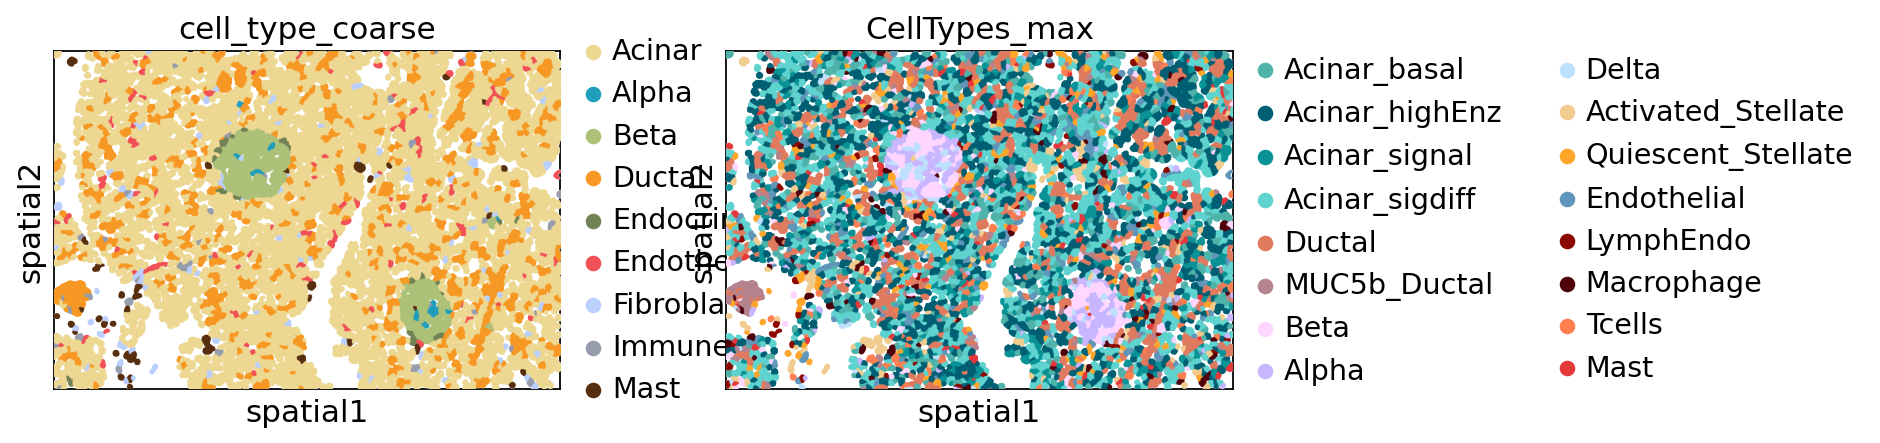

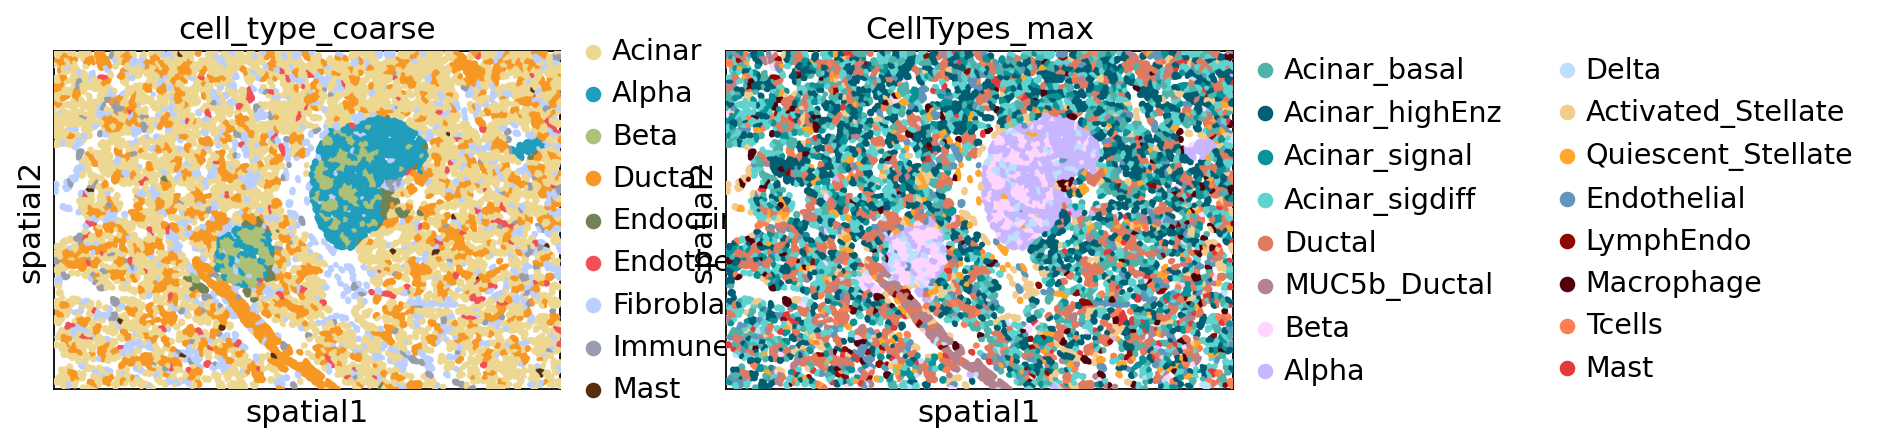

In [14]:
sq.pl.spatial_segment(adata_10,color=['cell_type_coarse','CellTypes_max'],ncols=2,library_key='fov',seg_cell_id='cell_ID',img=False)
sq.pl.spatial_segment(adata_12,color=['cell_type_coarse','CellTypes_max'],ncols=2,library_key='fov',seg_cell_id='cell_ID',img=False)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


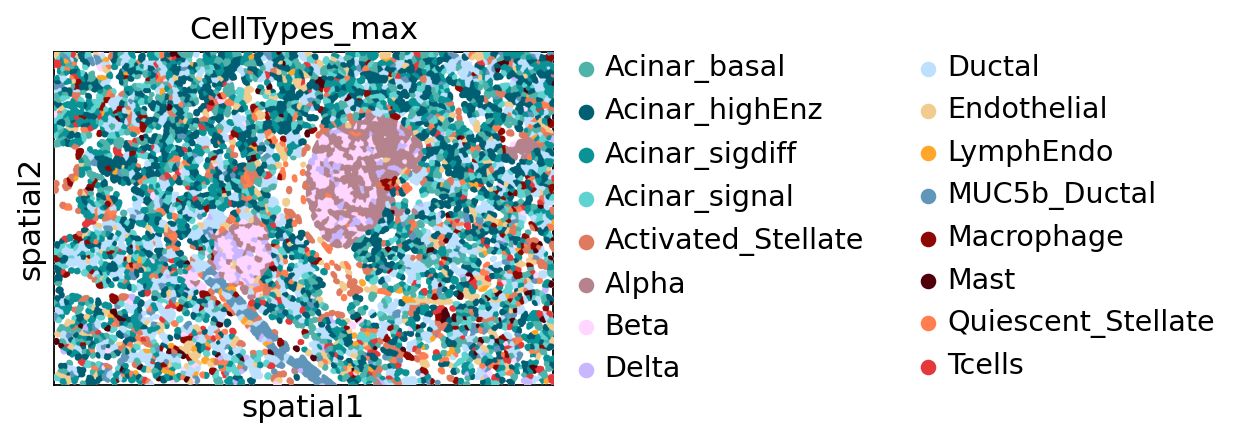

In [36]:
sq.pl.spatial_segment(adata_12,color=['CellTypes_max'],ncols=2,library_key='fov',seg_cell_id='cell_ID',img=False)

In [15]:
type(adata_10.X)

scipy.sparse._csr.csr_matrix

In [16]:
adata_10.X = adata_10.X.toarray()
adata_12.X = adata_12.X.toarray()

1. Noise distribution of the dataset per cell type 
- NCEM requires gaussian distribution not negative binomial 
- Important not to overnormalized -> the 

Acinar_basal
Acinar_highEnz
Acinar_sigdiff
Acinar_signal
Activated_Stellate
Alpha
Beta
Delta
Ductal
Endothelial
LymphEndo
MUC5b_Ductal
Macrophage
Mast
Quiescent_Stellate
Tcells


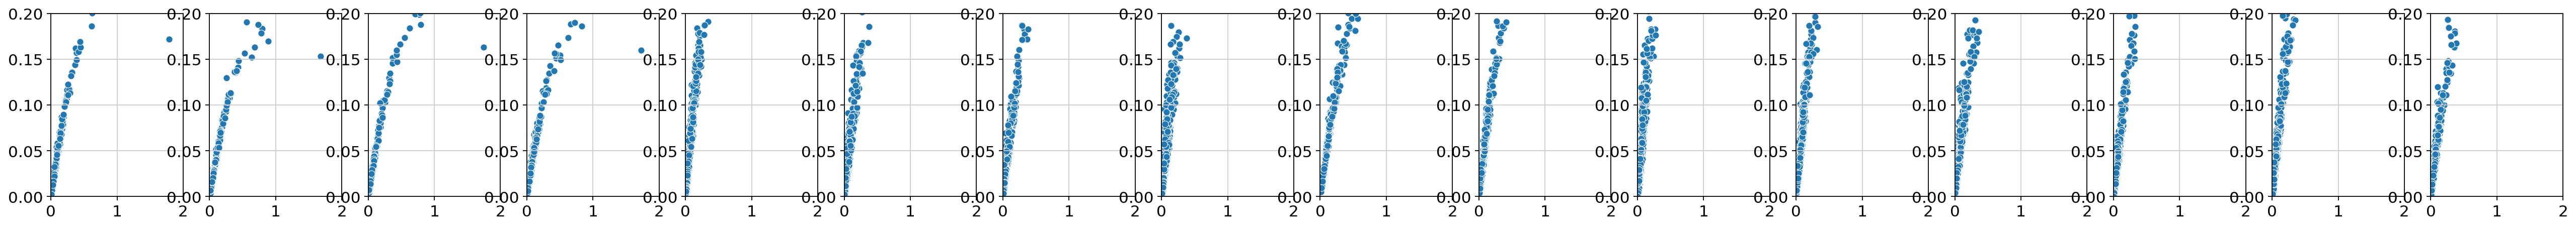

In [17]:
fig, ax = plt.subplots(1,len(np.unique(adata_10.obs['CellTypes_max'])), figsize=(40,3))
for i, ct in enumerate(np.unique(adata_10.obs['CellTypes_max'])):
    print(ct)
    mean = np.mean(adata_10[adata_10.obs['CellTypes_max']==ct].X, axis=0)
    var = np.var(adata_10[adata_10.obs['CellTypes_max']==ct].X, axis=0)
    g=sns.scatterplot(x=mean, y=var, ax=ax[i])
    g.set(ylim=(0, 0.2), xlim=(0,2))

Acinar_basal
Acinar_highEnz
Acinar_sigdiff
Acinar_signal
Activated_Stellate
Alpha
Beta
Delta
Ductal
Endothelial
LymphEndo
MUC5b_Ductal
Macrophage
Mast
Quiescent_Stellate
Tcells


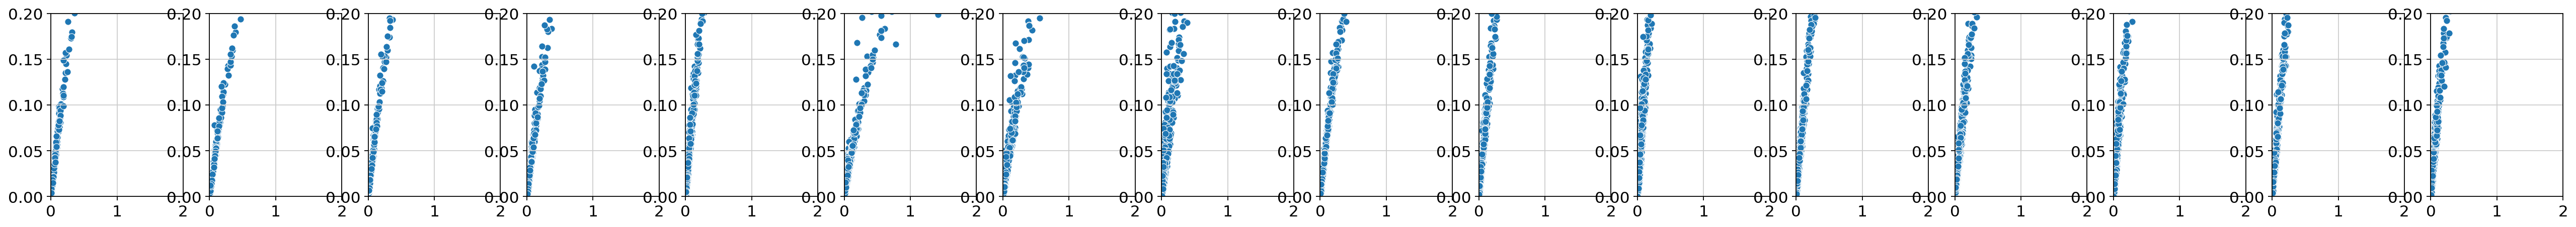

In [18]:
fig, ax = plt.subplots(1,len(np.unique(adata_12.obs['CellTypes_max'])), figsize=(40,3))
for i, ct in enumerate(np.unique(adata_12.obs['CellTypes_max'])):
    print(ct)
    mean = np.mean(adata_12[adata_12.obs['CellTypes_max']==ct].X, axis=0)
    var = np.var(adata_12[adata_12.obs['CellTypes_max']==ct].X, axis=0)
    g=sns.scatterplot(x=mean, y=var, ax=ax[i])
    g.set(ylim=(0, 0.2), xlim=(0,2))

### Pre-processing

In [19]:
adata_10.X.max(),adata_12.X.max()

(4.3824596, 4.3965755)

In [20]:
adata_10.layers['counts'].max(),adata_12.layers['counts'].max()

(226, 177)

#### the data seems normalized
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
adata.X

In [21]:
sq.gr.spatial_neighbors(
    adata_10,
    n_neighs=50,
    coord_type="generic",
    delaunay=True,
    library_key='fov'
)

sq.gr.spatial_neighbors(
    adata_12,
    n_neighs=50,
    coord_type="generic",
    delaunay=True,
    library_key='fov'
)

### Neighbors enrichment analysis

In [22]:
sq.gr.nhood_enrichment(adata_10,cluster_key='CellTypes_max')
sq.gr.nhood_enrichment(adata_12,cluster_key='CellTypes_max')

100%|██████████| 1000/1000 [00:00<00:00, 1623.28/s]


/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be trea

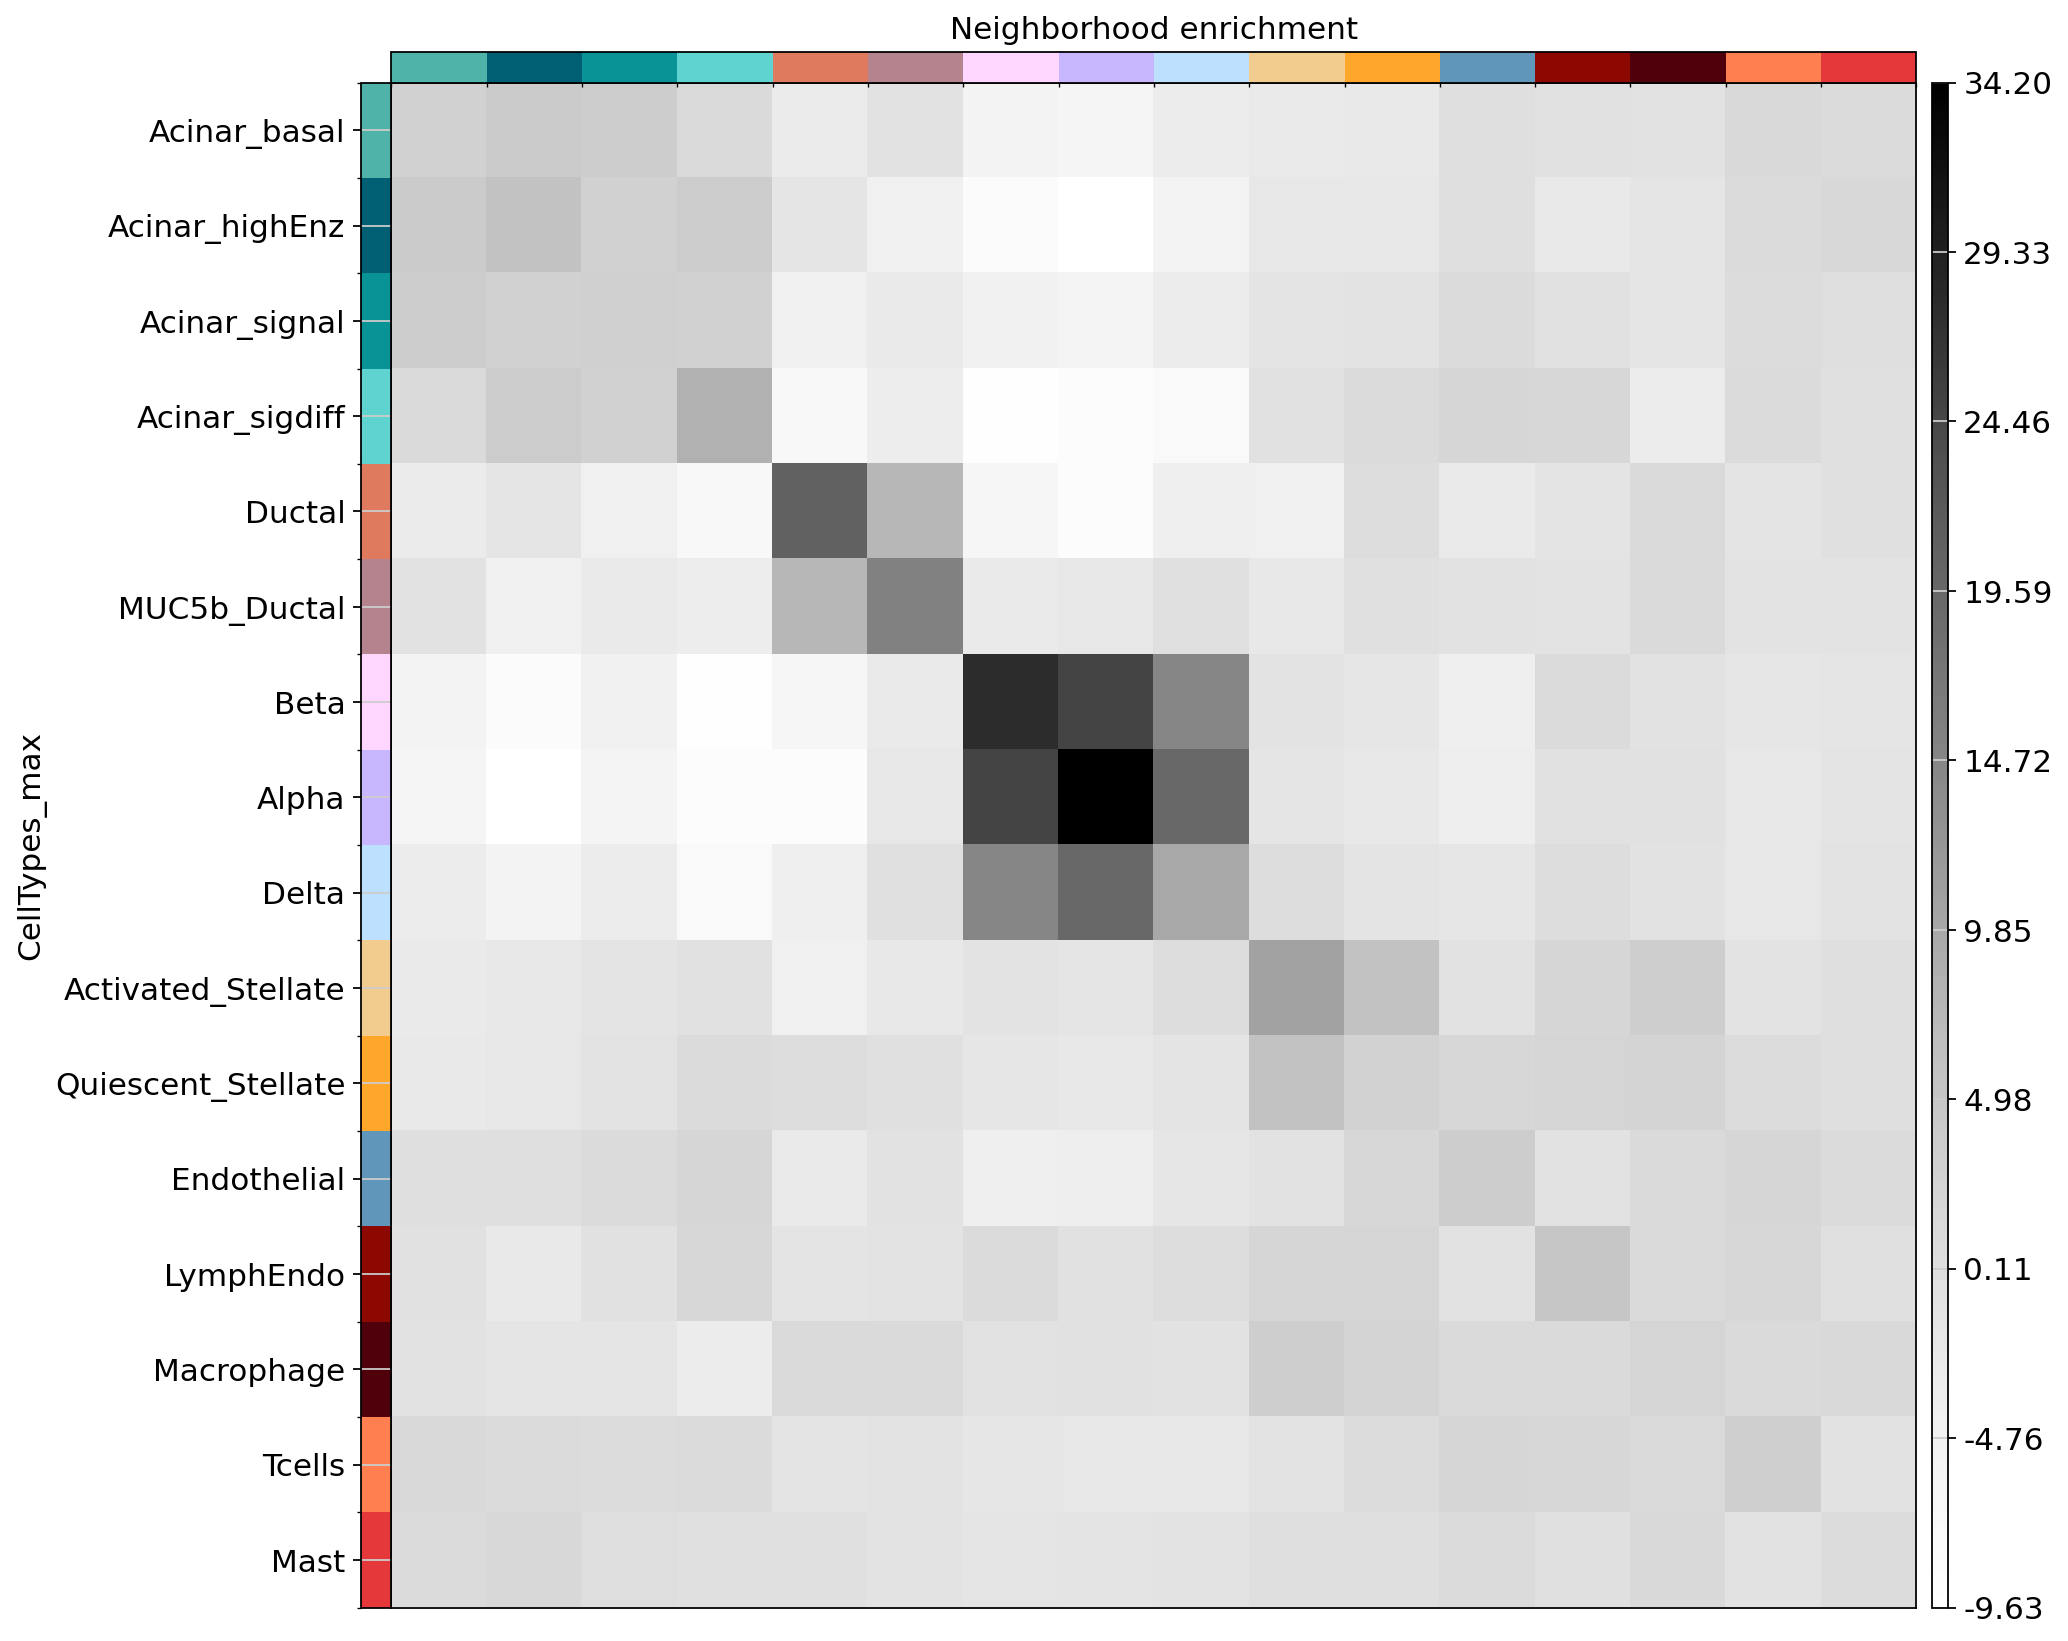

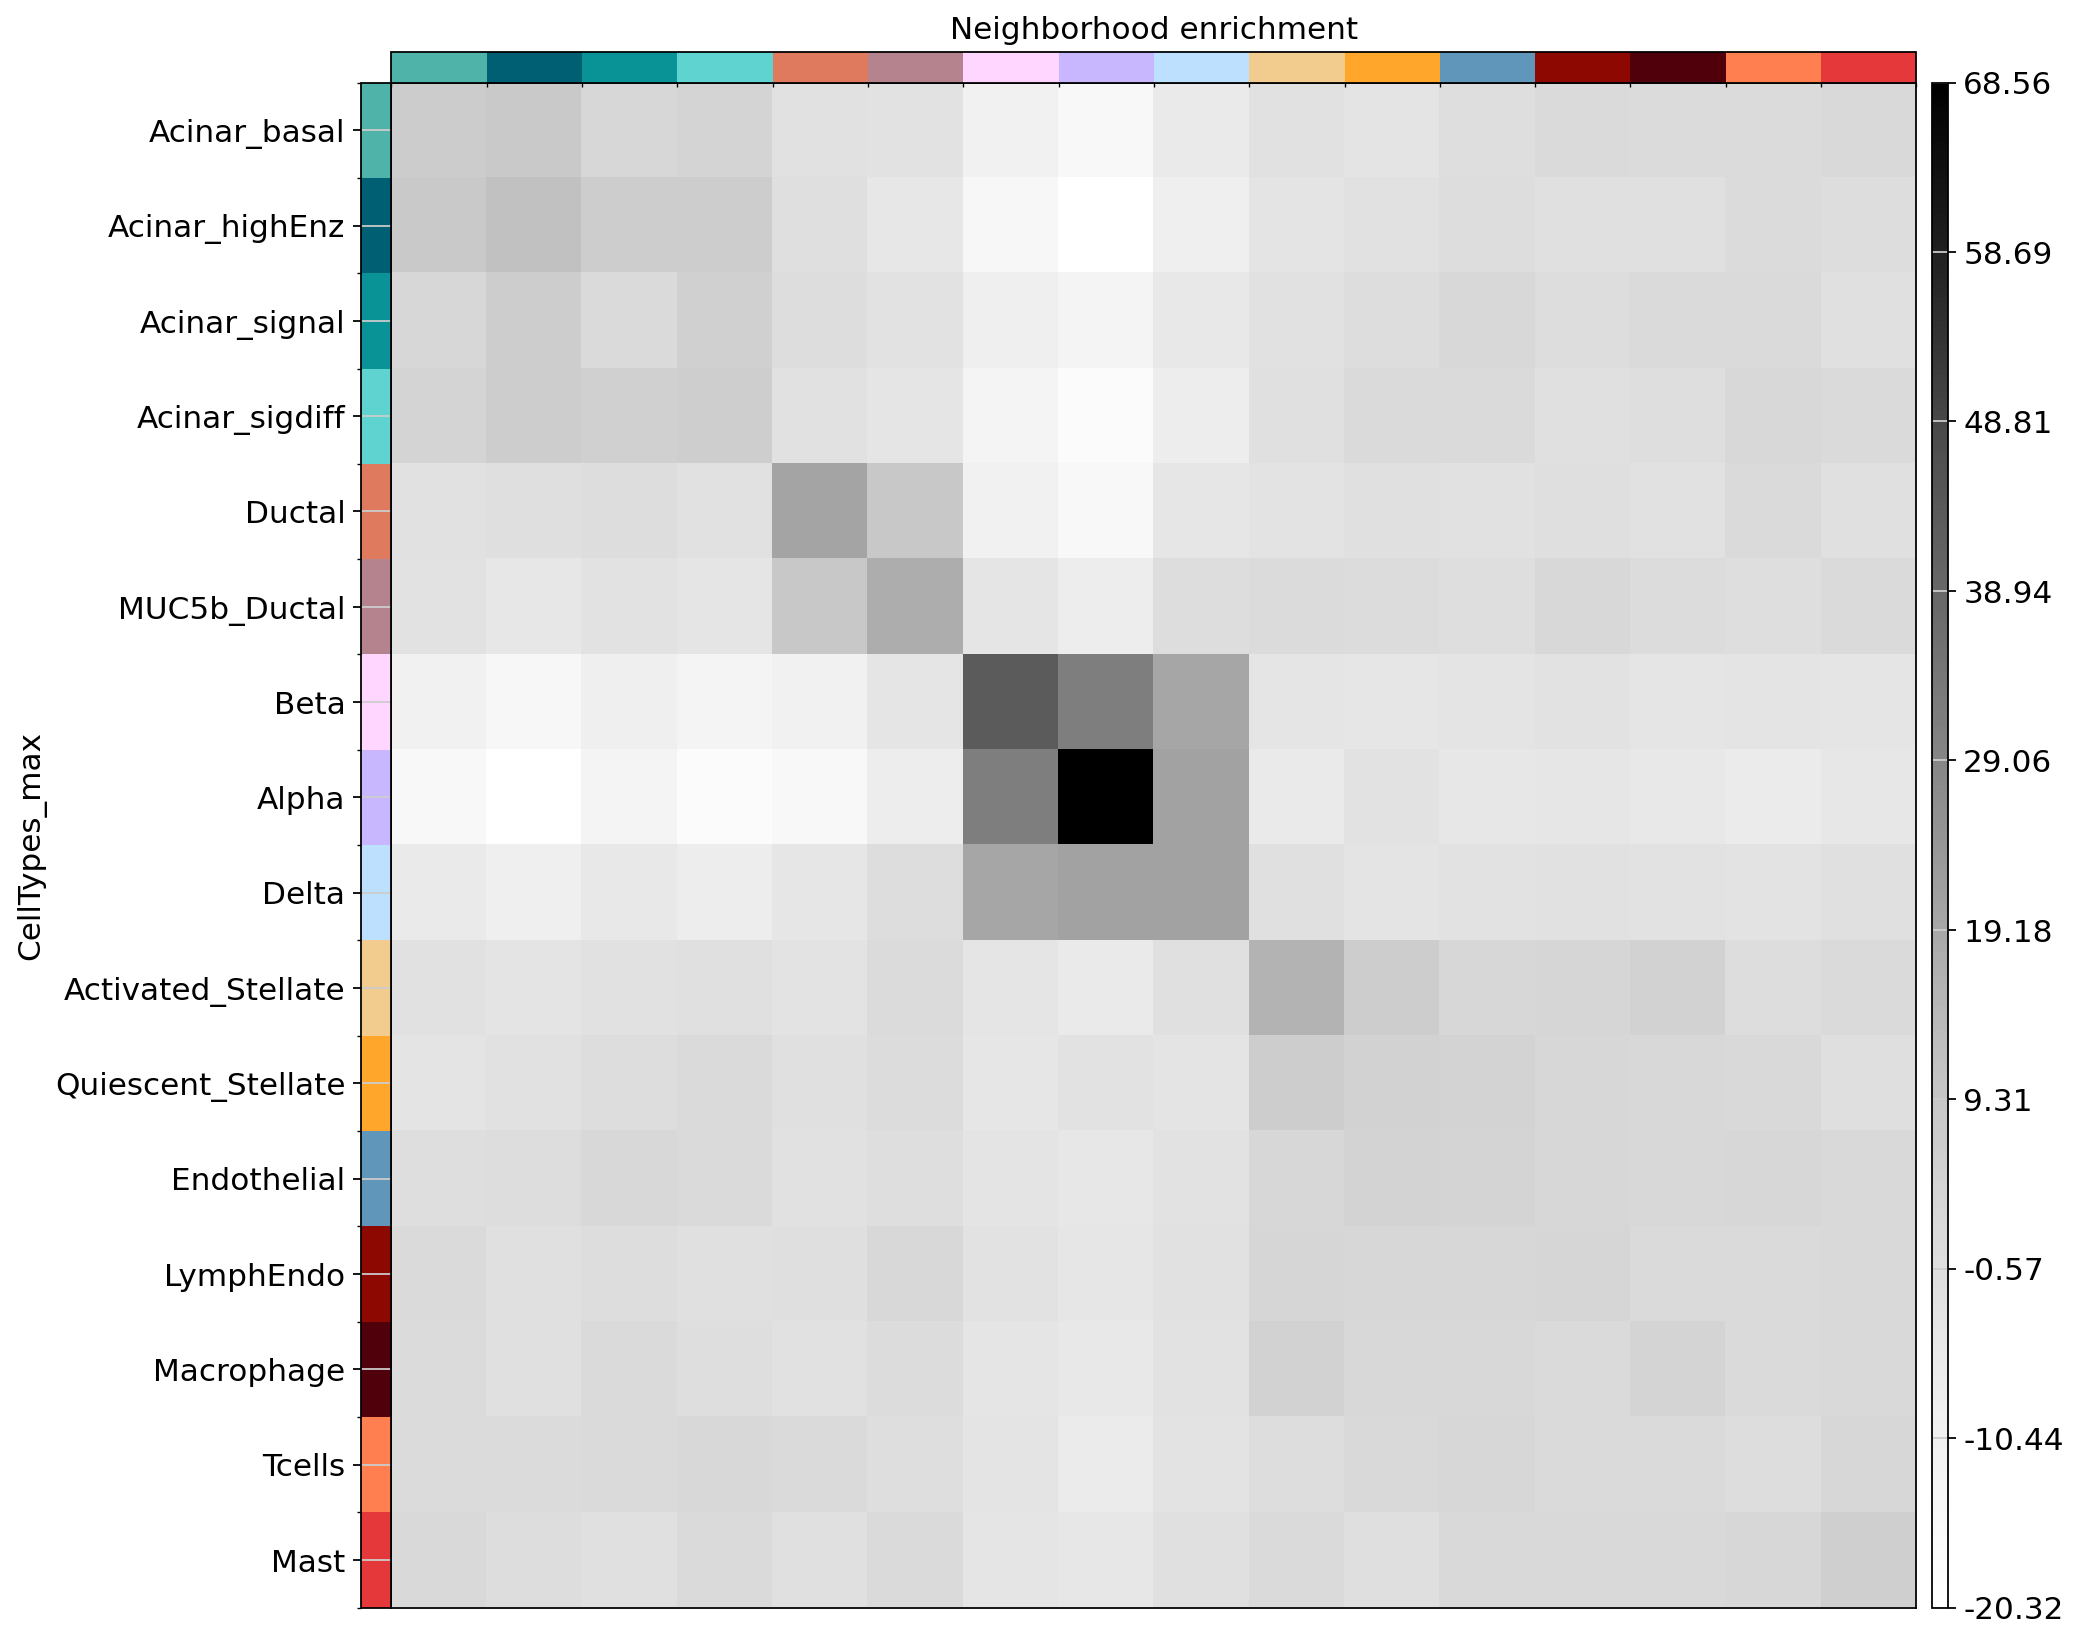

In [23]:
sq.pl.nhood_enrichment(adata_10, cluster_key='CellTypes_max',cmap='Greys')
sq.pl.nhood_enrichment(adata_12, cluster_key='CellTypes_max',cmap='Greys')

In [24]:
sq.gr.interaction_matrix(adata_10, cluster_key='CellTypes_max',weights=True)
sq.gr.interaction_matrix(adata_12, cluster_key='CellTypes_max',weights=True)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be trea

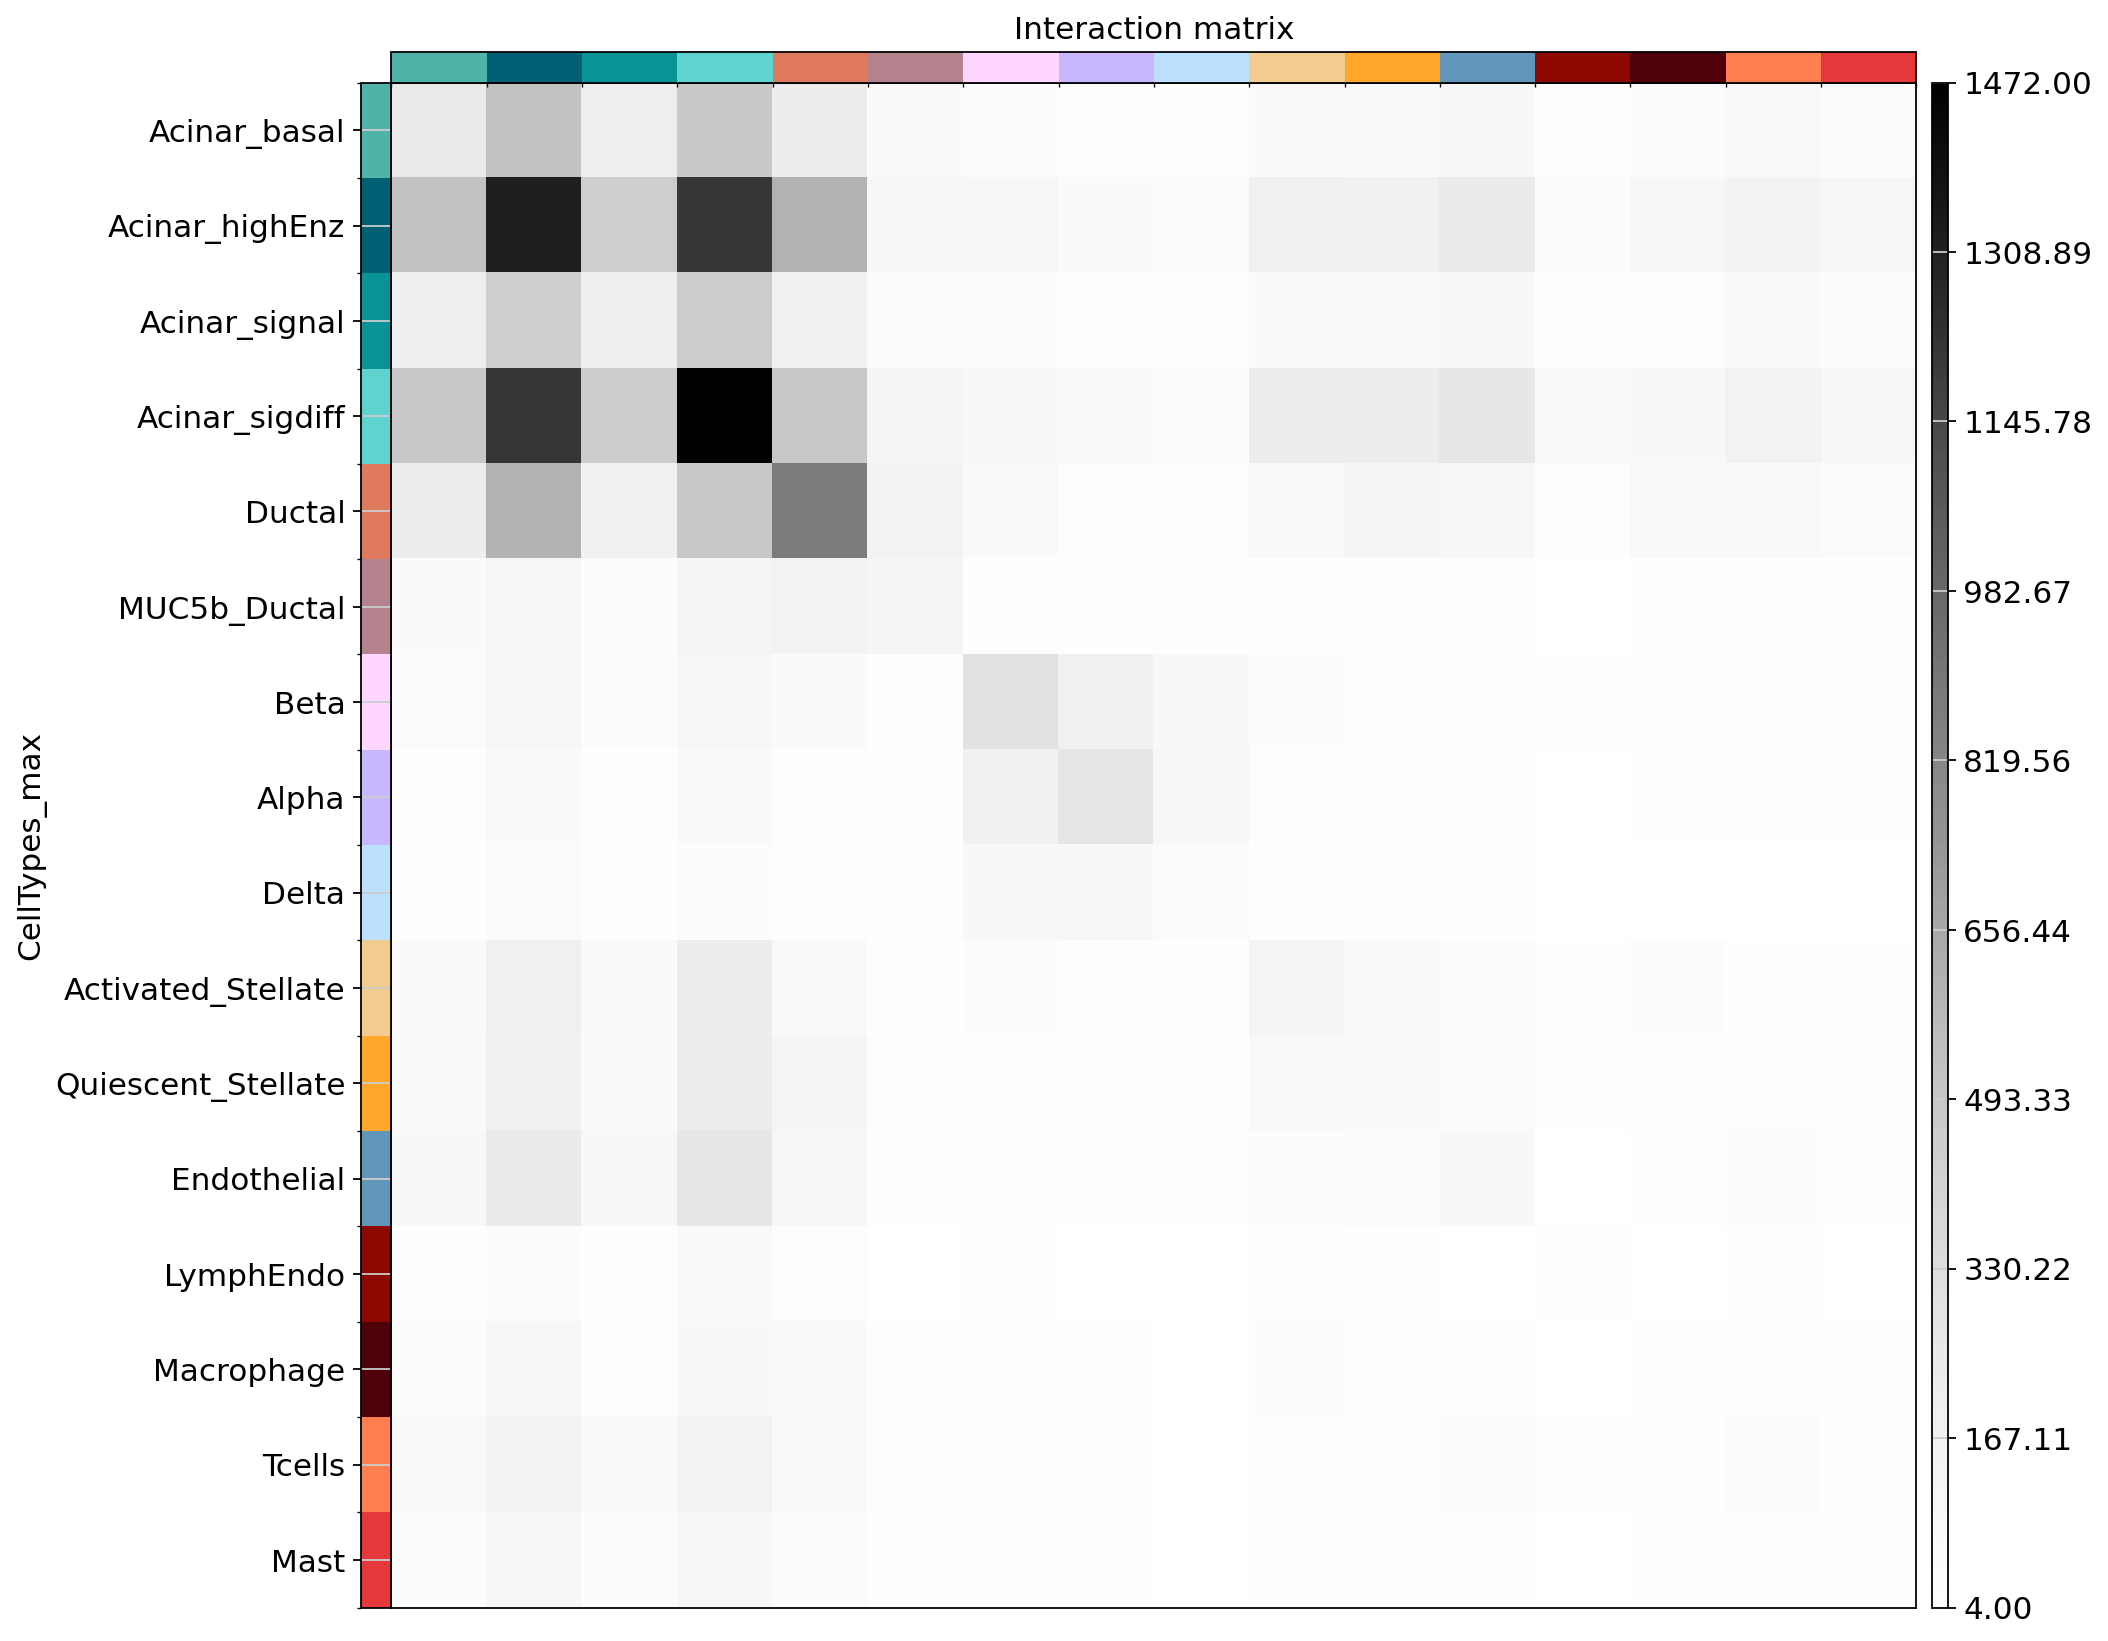

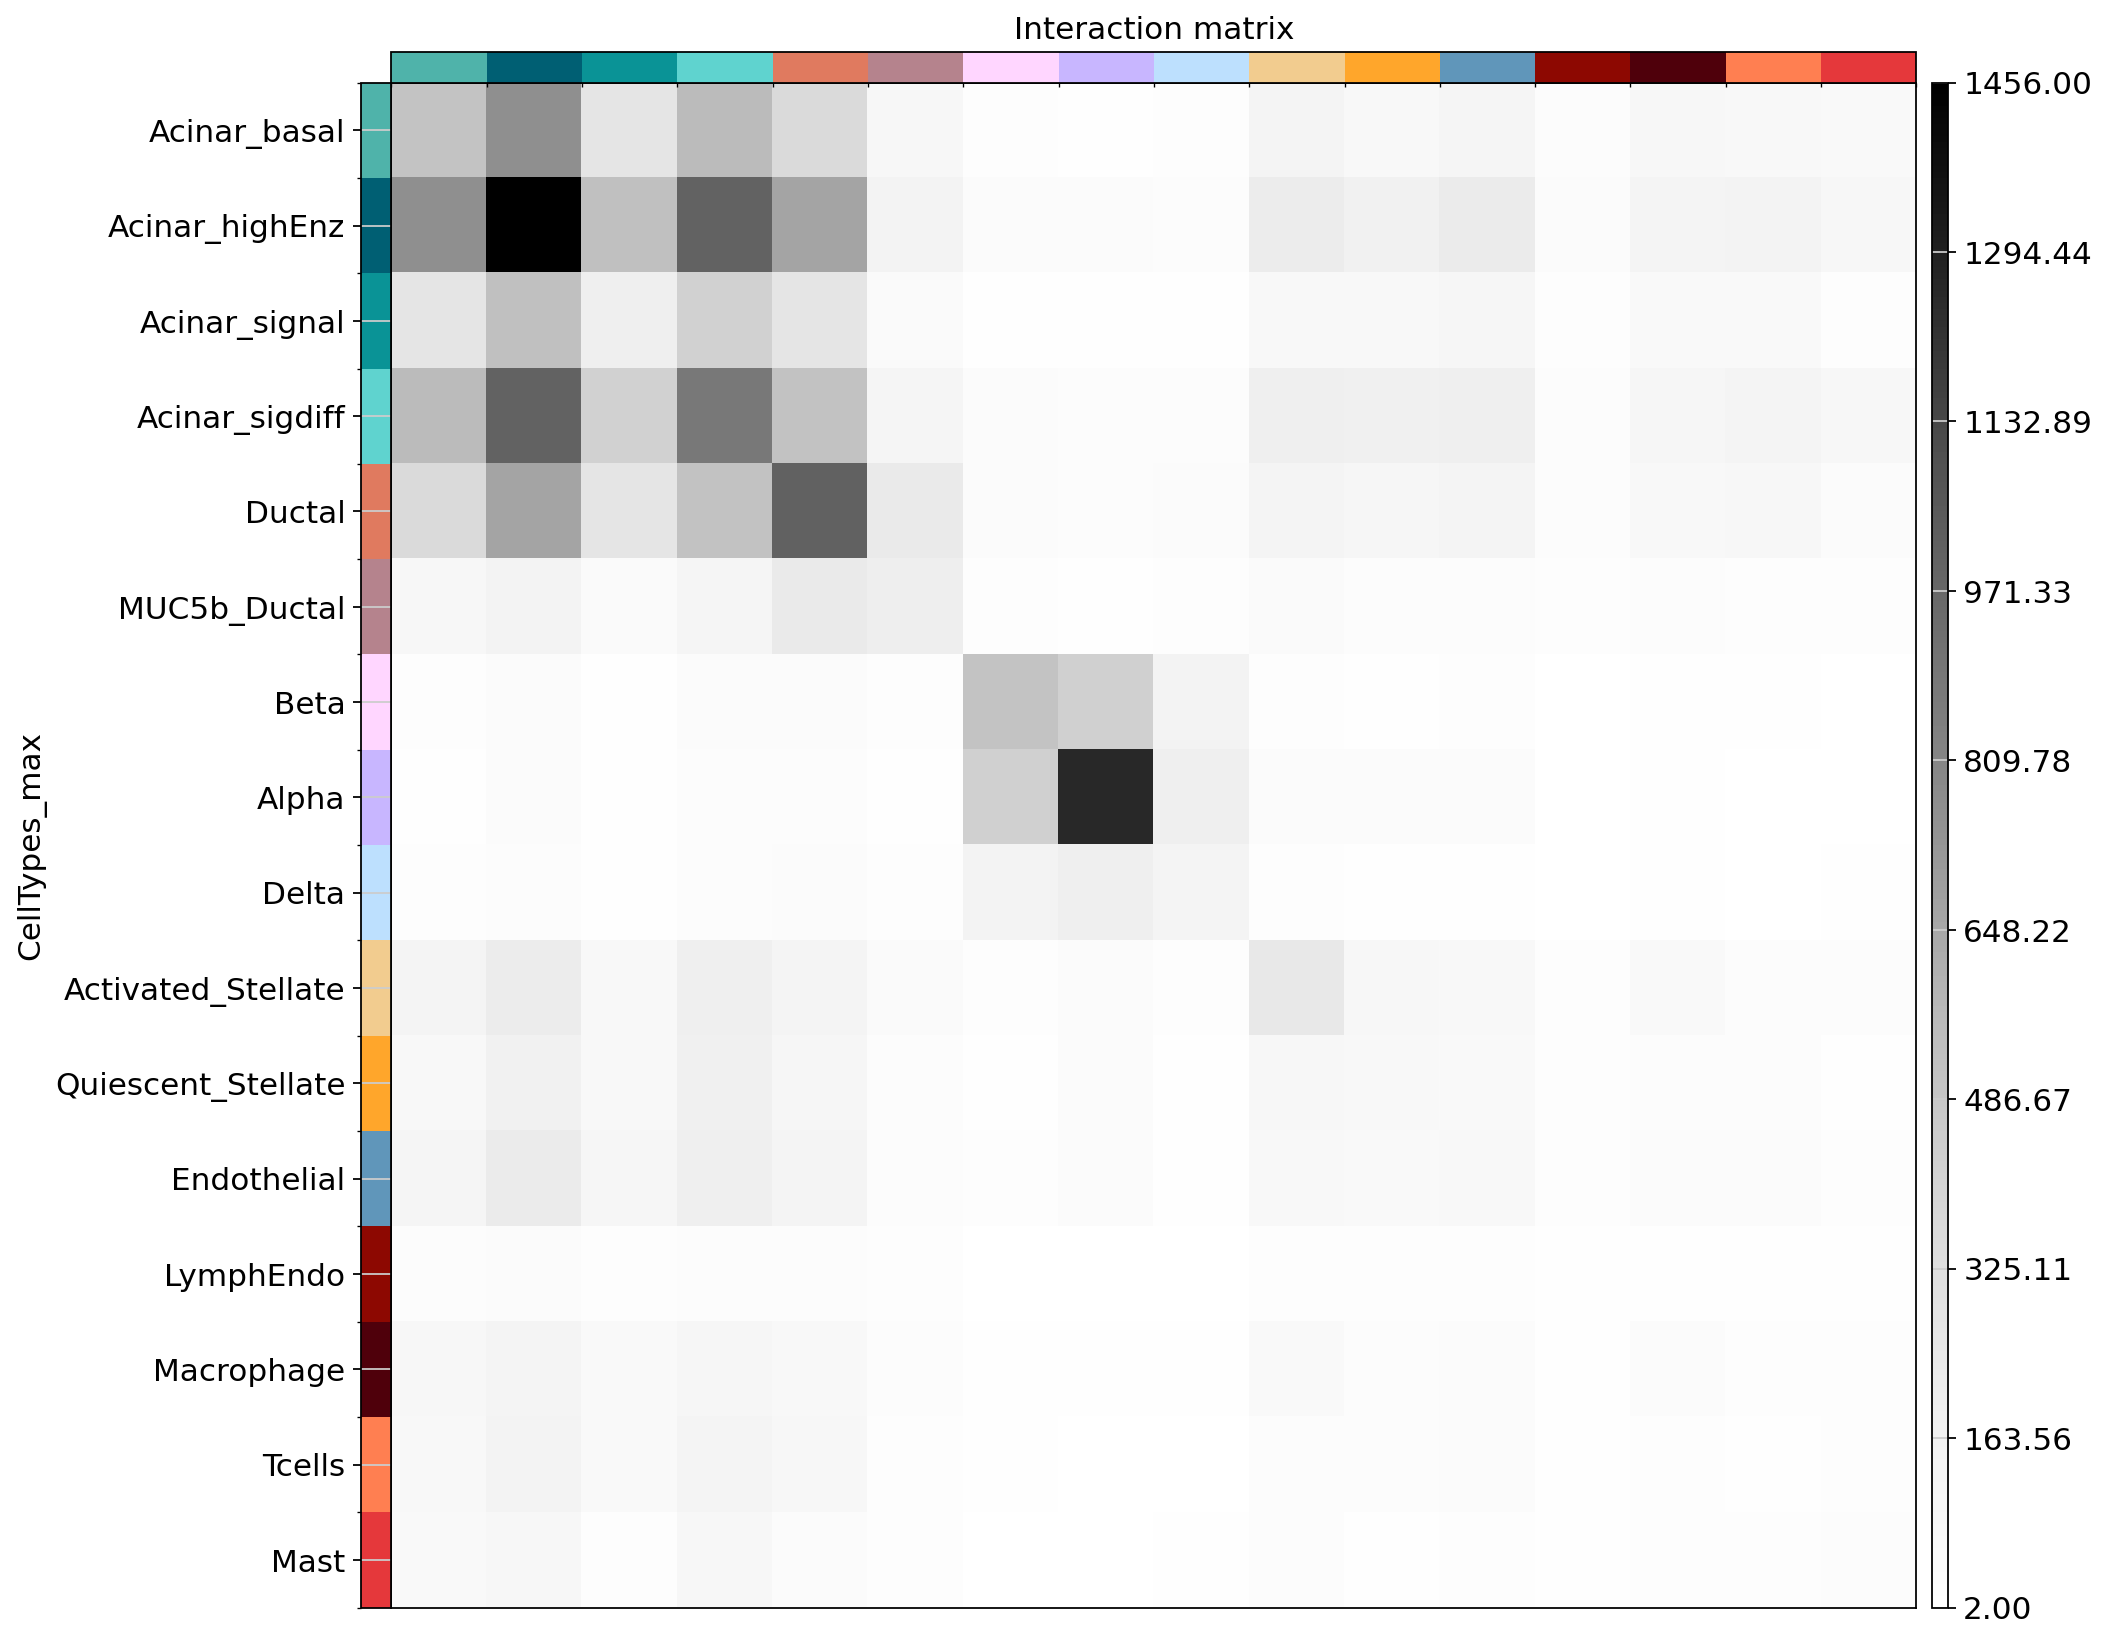

In [25]:
sq.pl.interaction_matrix(adata_10, cluster_key='CellTypes_max',cmap='Greys')
sq.pl.interaction_matrix(adata_12, cluster_key='CellTypes_max',cmap='Greys')

### Moran’s I score

The Moran’s I global spatial auto-correlation statistics evaluates whether features (i.e. genes) shows a pattern that is clustered, dispersed or random in the tissue are under consideration.

In [39]:
#sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata_10,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)
adata_10.uns["moranI"].head(10)

100%|██████████| 100/100 [00:20<00:00,  4.89/s]


I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
INS     0.760236        0.0  0.000077         0.0  0.009901  0.000152   
TTR     0.690693        0.0  0.000077         0.0  0.009901  0.000165   
GCG     0.672162        0.0  0.000077         0.0  0.009901  0.000152   
PRSS2   0.630984        0.0  0.000077         0.0  0.009901  0.000144   
CHGA    0.624503        0.0  0.000077         0.0  0.009901  0.000126   
REG1A   0.603012        0.0  0.000077         0.0  0.009901  0.000121   
CPB1    0.577031        0.0  0.000077         0.0  0.009901  0.000137   
IAPP    0.543026        0.0  0.000077         0.0  0.009901  0.000123   
SST     0.498951        0.0  0.000077         0.0  0.009901  0.000113   
SPINK1  0.458825        0.0  0.000077         0.0  0.009901  0.000131   

        pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
INS                  0.0                0.0         0.038928  
TTR                  0.0                0.0         0.038928  
GCG                  0.0                0.0         0.038928  
PRSS2                0.0                0.0         0.038928  
CHGA                 0.0                0.0         0.038928  
REG1A                0.0                0.0         0.038928  
CPB1                 0.0                0.0         0.038928  
IAPP                 0.0                0.0         0.038928  
SST                  0.0                0.0         0.038928  
SPINK1               0.0                0.0         0.038928

In [49]:
#sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata_12,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)
adata_12.uns["moranI"].head(50)

100%|██████████| 100/100 [00:25<00:00,  3.88/s]


I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
TTR       0.841436        0.0  0.000065         0.0  0.009901  0.000161   
GCG       0.813863        0.0  0.000065         0.0  0.009901  0.000157   
CHGA      0.765895        0.0  0.000065         0.0  0.009901  0.000138   
INS       0.757733        0.0  0.000065         0.0  0.009901  0.000162   
PRSS2     0.732667        0.0  0.000065         0.0  0.009901  0.000146   
REG1A     0.714490        0.0  0.000065         0.0  0.009901  0.000130   
CPB1      0.674632        0.0  0.000065         0.0  0.009901  0.000146   
SPINK1    0.551265        0.0  0.000065         0.0  0.009901  0.000123   
IAPP      0.515339        0.0  0.000065         0.0  0.009901  0.000091   
SCG5      0.422968        0.0  0.000065         0.0  0.009901  0.000092   
SST       0.409657        0.0  0.000065         0.0  0.009901  0.000107   
HLA-A     0.379748        0.0  0.000065         0.0  0.009901  0.000102   
G6PC2     0.371600        0.0  0.000065         0.0  0.009901  0.000073   
GC        0.358279        0.0  0.000065         0.0  0.009901  0.000075   
OLFM4     0.312706        0.0  0.000065         0.0  0.009901  0.000067   
SERPINA3  0.312608        0.0  0.000065         0.0  0.009901  0.000087   
TIMP1     0.253259        0.0  0.000065         0.0  0.009901  0.000084   
SERPINA1  0.251805        0.0  0.000065         0.0  0.009901  0.000065   
MEG3      0.216632        0.0  0.000065         0.0  0.009901  0.000049   
CALM1     0.207752        0.0  0.000065         0.0  0.009901  0.000066   
ANXA4     0.196152        0.0  0.000065         0.0  0.009901  0.000039   
CUZD1     0.192095        0.0  0.000065         0.0  0.009901  0.000073   
MZT2A     0.187667        0.0  0.000065         0.0  0.009901  0.000056   
CLU       0.185050        0.0  0.000065         0.0  0.009901  0.000054   
MIF       0.183529        0.0  0.000065         0.0  0.009901  0.000054   
B2M       0.181528        0.0  0.000065         0.0  0.009901  0.000063   
FOS       0.177653        0.0  0.000065         0.0  0.009901  0.000058   
GSN       0.176955        0.0  0.000065         0.0  0.009901  0.000063   
HLA-C     0.174563        0.0  0.000065         0.0  0.009901  0.000047   
KRT8      0.160763        0.0  0.000065         0.0  0.009901  0.000046   
SOD2      0.160204        0.0  0.000065         0.0  0.009901  0.000038   
GPX3      0.147575        0.0  0.000065         0.0  0.009901  0.000052   
TYK2      0.138476        0.0  0.000065         0.0  0.009901  0.000060   
MALAT1    0.137195        0.0  0.000065         0.0  0.009901  0.000056   
CASR      0.134170        0.0  0.000065         0.0  0.009901  0.000055   
APOD      0.131242        0.0  0.000065         0.0  0.009901  0.000055   
FGFR3     0.128261        0.0  0.000065         0.0  0.009901  0.000053   
ZFP36     0.125585        0.0  0.000065         0.0  0.009901  0.000049   
KRT7      0.123177        0.0  0.000065         0.0  0.009901  0.000049   
AZU1      0.120858        0.0  0.000065         0.0  0.009901  0.000053   
MGP       0.120499        0.0  0.000065         0.0  0.009901  0.000048   
DDR1      0.118805        0.0  0.000065         0.0  0.009901  0.000043   
BMP5      0.118719        0.0  0.000065         0.0  0.009901  0.000064   
CALM2     0.117341        0.0  0.000065         0.0  0.009901  0.000060   
ANXA2     0.114521        0.0  0.000065         0.0  0.009901  0.000041   
KRT19     0.112346        0.0  0.000065         0.0  0.009901  0.000056   
RGS2      0.111413        0.0  0.000065         0.0  0.009901  0.000047   
COL6A2    0.110469        0.0  0.000065         0.0  0.009901  0.000046   
IGFBP7    0.109133        0.0  0.000065         0.0  0.009901  0.000046   
VEGFA     0.105096        0.0  0.000065         0.0  0.009901  0.000040   

          pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
TTR                    0.0                0.0         0.027382  
GCG                    0.0                0.0         0.02738

In [50]:
adata_12.uns["moranI"].head(50).index.values

array(['TTR', 'GCG', 'CHGA', 'INS', 'PRSS2', 'REG1A', 'CPB1', 'SPINK1',
       'IAPP', 'SCG5', 'SST', 'HLA-A', 'G6PC2', 'GC', 'OLFM4', 'SERPINA3',
       'TIMP1', 'SERPINA1', 'MEG3', 'CALM1', 'ANXA4', 'CUZD1', 'MZT2A',
       'CLU', 'MIF', 'B2M', 'FOS', 'GSN', 'HLA-C', 'KRT8', 'SOD2', 'GPX3',
       'TYK2', 'MALAT1', 'CASR', 'APOD', 'FGFR3', 'ZFP36', 'KRT7', 'AZU1',
       'MGP', 'DDR1', 'BMP5', 'CALM2', 'ANXA2', 'KRT19', 'RGS2', 'COL6A2',
       'IGFBP7', 'VEGFA'], dtype=object)

In [52]:
# Assuming 'adata' is your AnnData object
genes = adata_12.uns["moranI"].to_csv("genes.txt", sep="\t")

In [ ]:
adata.obs.cell_type_coarse.value_counts()

In [ ]:
sc.pl.matrixplot(adata, adata.uns["moranI"].head(10).index.values, groupby='cell_type_coarse', cmap='Greys')
#mp.add_totals().style(edge_color='black').show()

In [ ]:
sq.pl.spatial_segment(
    adata,
    library_id="10",
    seg_cell_id="cell_ID",
    library_key="fov",
    color=["GCG", "INS", "CPB1","SPINK1"],
    size=60,
    img=False,cmap="RdYlBu_r"
)

### Ligand receptor analysis

In [46]:
sq.gr.ligrec(adata_10,cluster_key='CellTypes_max',use_raw=False, alpha=0.001)
sq.gr.ligrec(adata_12,cluster_key='CellTypes_max',use_raw=False, alpha=0.001)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:733: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = data.groupby("clusters")
100%|██████████| 1000/1000 [00:02<00:00, 360.88permutation/s]
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:733: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = data.groupby("clusters")
100%|██████████| 1000/1000 [00:02<00:00, 347.47permutation/s]


/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_ligrec.py:306: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for cls, size in (pvals.groupby(level=0, axis=1)).size().to_dict().items():
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


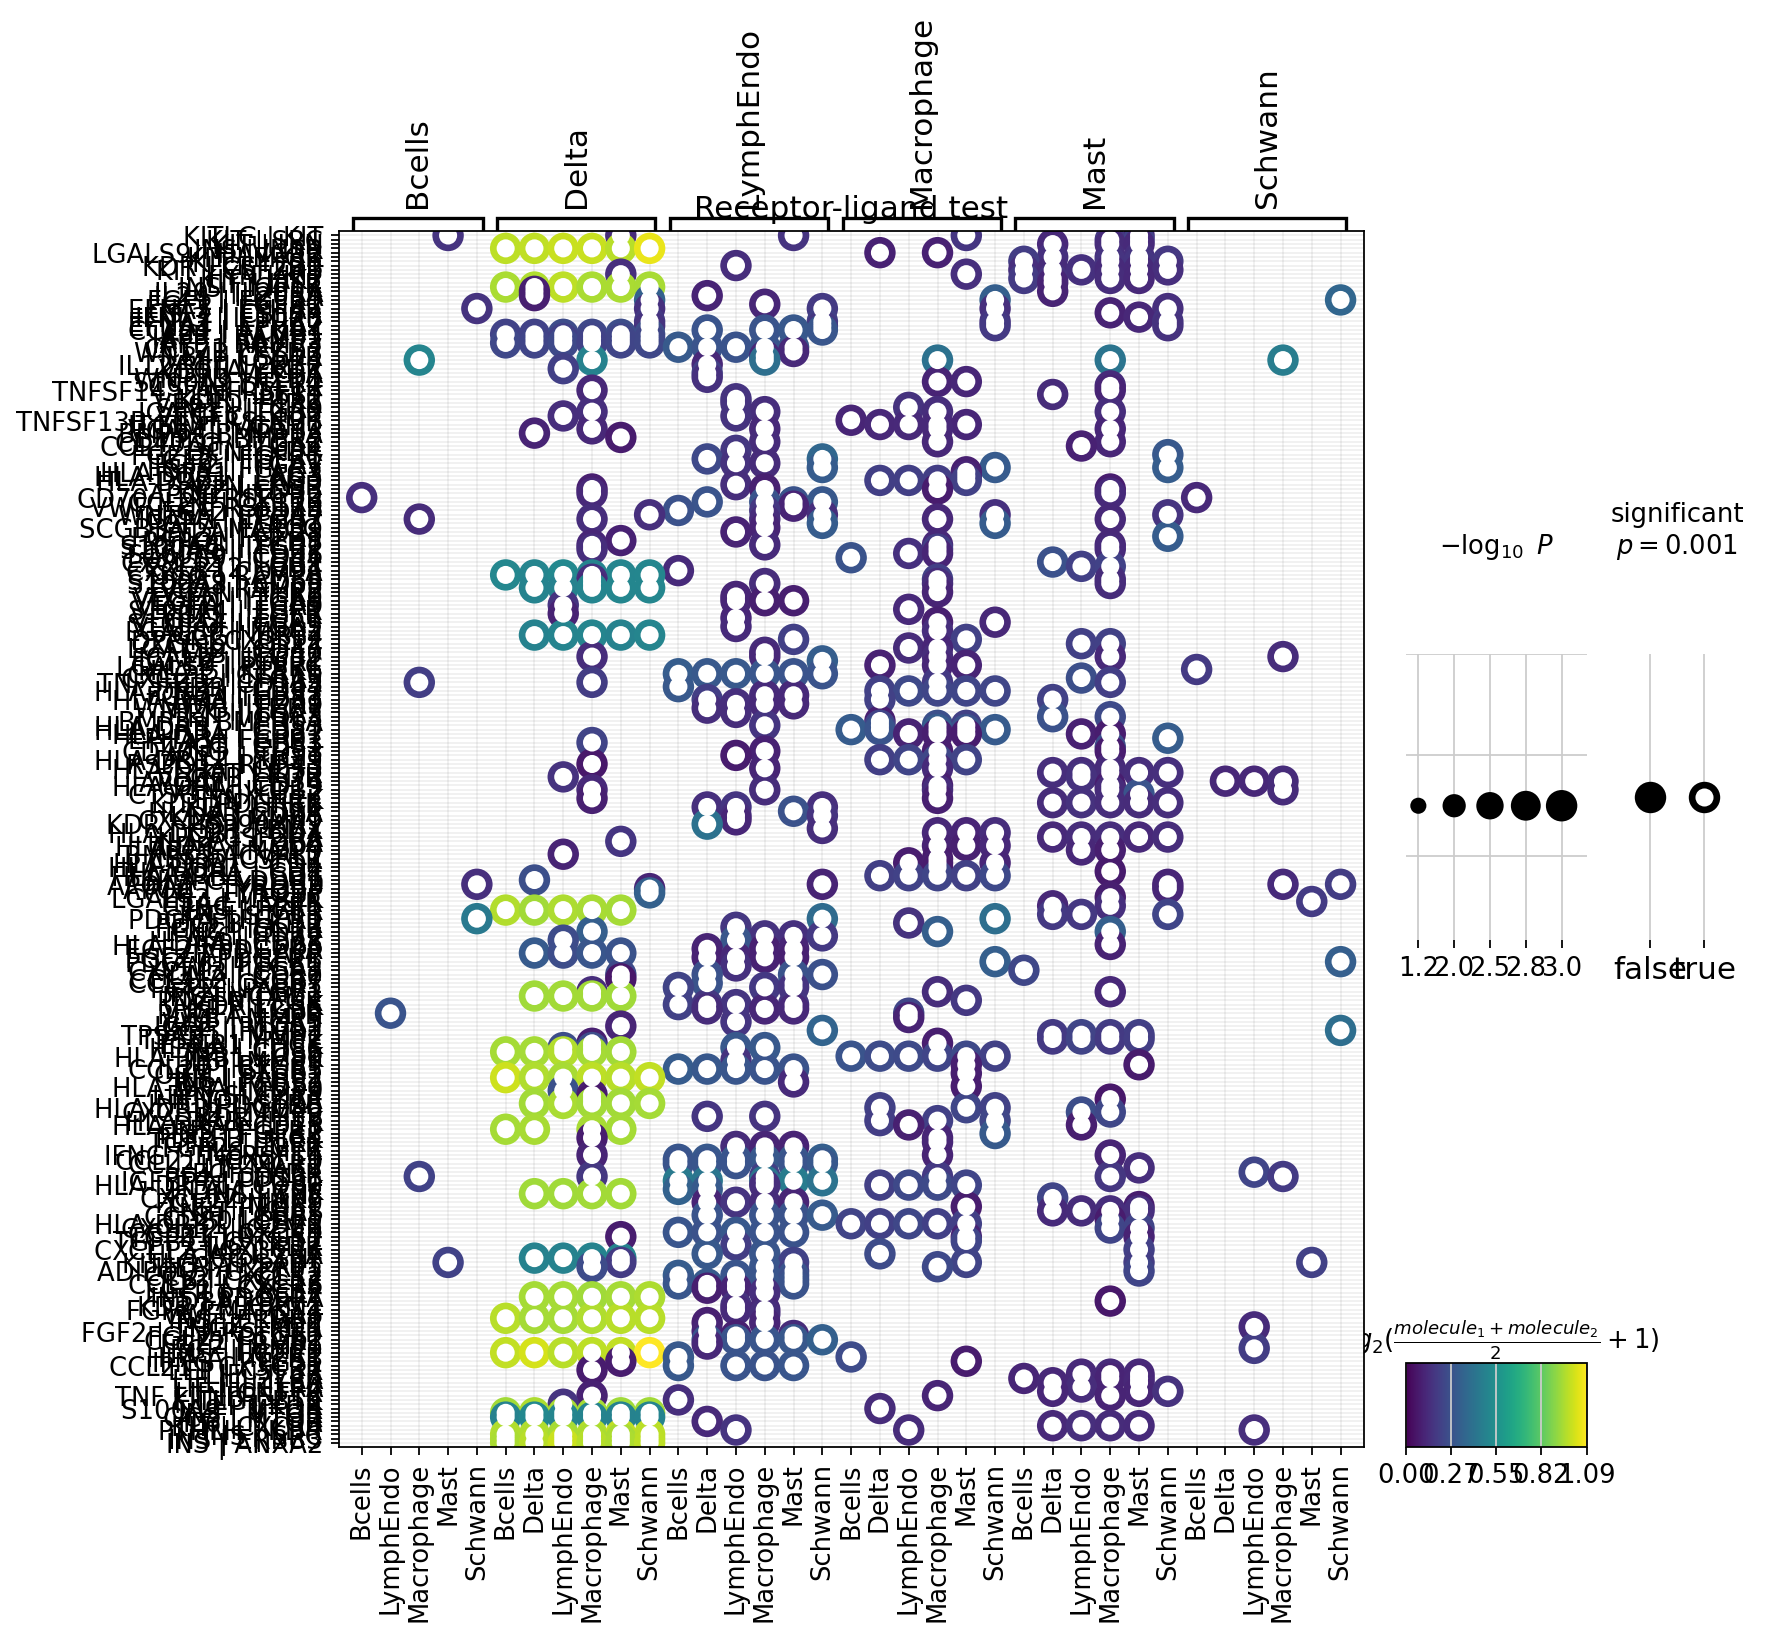

In [47]:
sq.pl.ligrec(adata_10, cluster_key='CellTypes_max',pvalue_threshold=0.0001,
             remove_nonsig_interactions=True, remove_empty_interactions=True,figsize = (10,10))

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_ligrec.py:306: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for cls, size in (pvals.groupby(level=0, axis=1)).size().to_dict().items():
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


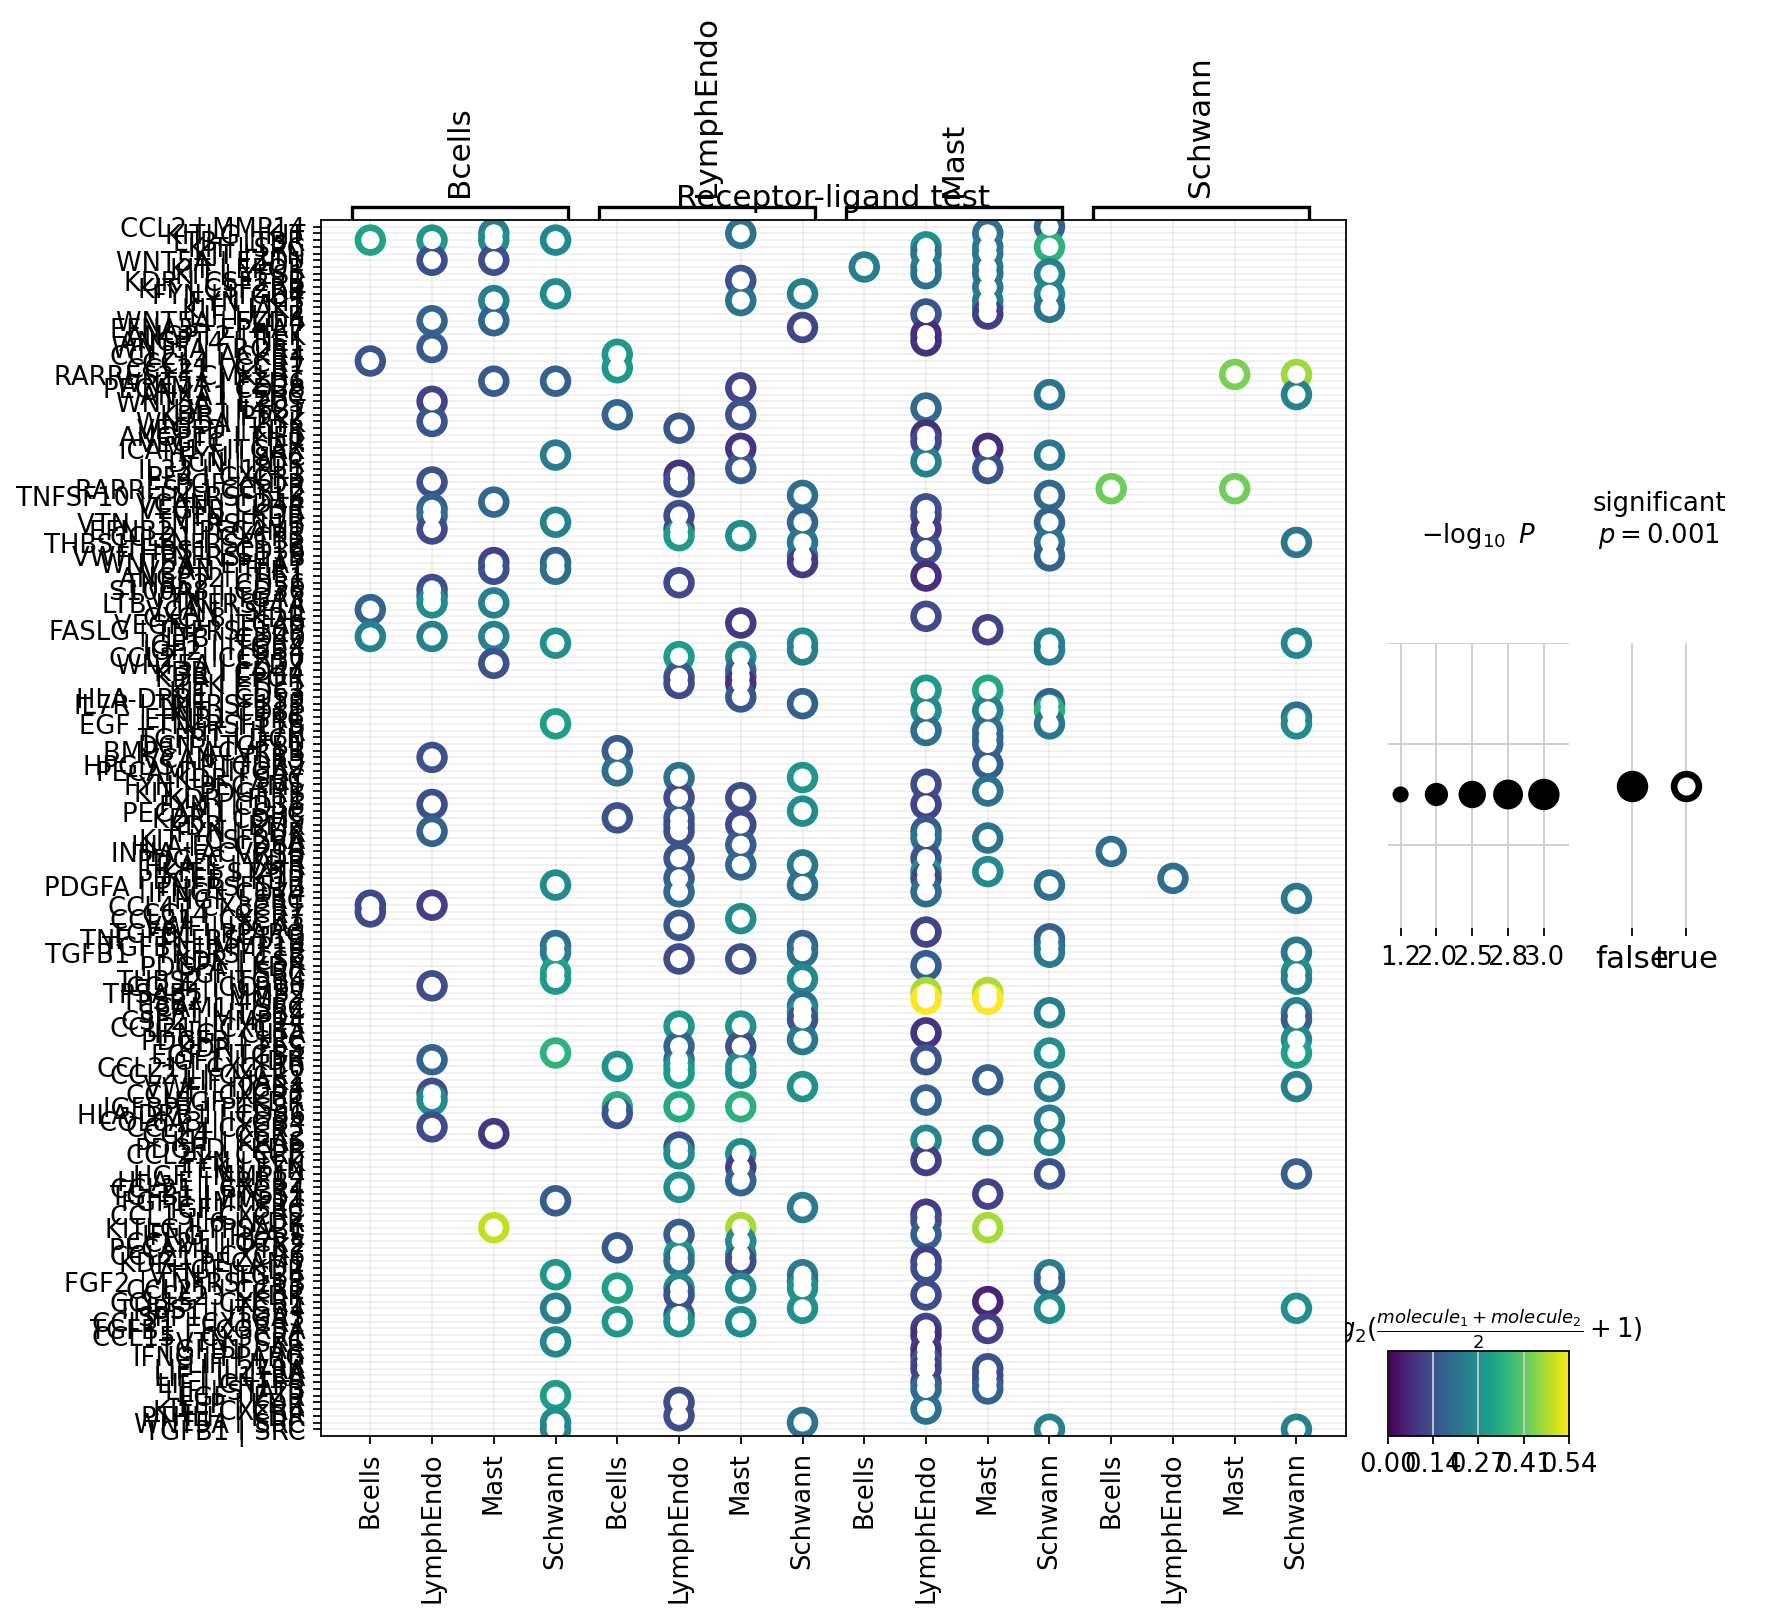

In [44]:
sq.pl.ligrec(adata_12, cluster_key='CellTypes_max',pvalue_threshold=0.0001,
             remove_nonsig_interactions=True, remove_empty_interactions=True,figsize = (10,10))

### NCEM

In [26]:
from ncem.tl.fit.glm import linear_ncem

In [27]:
adata_10 = linear_ncem(adata=adata_10, key_type='CellTypes_max', key_graph='spatial_connectivities')
adata_12 = linear_ncem(adata=adata_12, key_type='CellTypes_max', key_graph='spatial_connectivities')

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [28]:
adata_12.obs['CellTypes_max'].value_counts()

CellTypes_max
Acinar_highEnz        946
Acinar_sigdiff        764
Ductal                634
Acinar_basal          540
Acinar_signal         377
Alpha                 365
Activated_Stellate    243
Beta                  232
Endothelial           208
MUC5b_Ductal          189
Quiescent_Stellate    181
Macrophage            138
Tcells                125
Delta                 119
Mast                   90
LymphEndo              57
Name: count, dtype: int64

In [29]:
adata_10.obs['CellTypes_max'].value_counts()

CellTypes_max
Acinar_sigdiff        914
Acinar_highEnz        897
Ductal                522
Acinar_basal          366
Acinar_signal         324
Beta                  186
Endothelial           184
Activated_Stellate    173
Quiescent_Stellate    166
Alpha                 143
MUC5b_Ductal          133
Tcells                119
Macrophage             93
Delta                  79
Mast                   78
LymphEndo              46
Name: count, dtype: int64

In [30]:
adata_10, adata_12

(AnnData object with n_obs × n_vars = 4423 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'CellTypes_max_colors', 'cell_type_coarse_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'umap', 'spatial_neighbors', 'CellTypes_max_nhood_enrichment', 'CellTypes_max_interactions', 'nc

#### Exploring interesting interactions

In [43]:
adata_10.varm['ncem_fdr_pvals']

index_Acinar_basal:neighbor_Acinar_basal  \
AATK                                      1.000000   
ABL1                                      1.000000   
ABL2                                      0.999217   
ACE                                       1.000000   
ACE2                                      1.000000   
...                                            ...   
NegPrb19                                  1.000000   
NegPrb20                                  1.000000   
NegPrb21                                  1.000000   
NegPrb22                                  1.000000   
NegPrb23                                  1.000000   

          index_Acinar_highEnz:neighbor_Acinar_basal  \
AATK                                        0.842731   
ABL1                                        0.963830   
ABL2                                        1.000000   
ACE                                         1.000000   
ACE2                                        1.000000   
...                                              ...   
NegPrb19                                    0.951971   
NegPrb20                                    0.732583   
NegPrb21                                    1.000000   
NegPrb22                                    0.895203   
NegPrb23                                    1.000000   

          index_Acinar_sigdiff:neighbor_Acinar_basal  \
AATK                                        1.000000   
ABL1                                        1.000000   
ABL2                                        1.000000   
ACE                                         1.000000   
ACE2                                        1.000000   
...                                              ...   
NegPrb19                                    0.856046   
NegPrb20                                    1.000000   
NegPrb21                                    1.000000   
NegPrb22                                    0.769121   
NegPrb23                                    1.000000   

          index_Acinar_signal:neighbor_Acinar_basal  \
AATK                                        1.00000   
ABL1                                        1.00000   
ABL2                                        1.00000   
ACE                                         1.00000   
ACE2                                        1.00000   
...                                             ...   
NegPrb19                                    1.00000   
NegPrb20                                    0.98976   
NegPrb21                                    1.00000   
NegPrb22                                    1.00000   
NegPrb23                                    1.00000   

          index_Activated_Stellate:neighbor_Acinar_basal  \
AATK                                            1.000000   
ABL1                                            1.000000   
ABL2                                            1.000000   
ACE                                             1.000000   
ACE2                                            1.000000   
...                                                  ...   
NegPrb19                                        1.000000   
NegPrb20                                        0.733393   
NegPrb21                                        1.000000   
NegPrb22                                        1.000000   
NegPrb23                                        0.752349   

          index_Alpha:neighbor_Acinar_basal  index_Beta:neighbor_Acinar_basal  \
AATK                               0.530085                          1.000000   
ABL1                               1.000000                          1.000000   
ABL2                               1.000000                          1.000000   
ACE                                0.936990                          1.000000   
ACE2                               1.000000                          1.000000   
...                                     ...                               ...   
NegPrb19                           0.877335                       

In [47]:
df = pd.DataFrame(np.sum(np.absolute(adata_10.varm['ncem_params'])))
df_int_10 = pd.DataFrame(columns=adata_10.obs['CellTypes_max'].cat.categories, index=adata_10.obs['CellTypes_max'].cat.categories,dtype=float)
for s in adata_10.obs['CellTypes_max'].cat.categories:
    for r in adata_10.obs['CellTypes_max'].cat.categories: 
        index_value = 'index_'+s+':neighbor_'+r
        df_int_10.at[s,r] = df.loc[index_value][0]
df_int_10

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Acinar_basal  Acinar_highEnz  Acinar_sigdiff  \
Acinar_basal           11.609338       13.646440       12.230427   
Acinar_highEnz          7.253035        9.121616        8.105344   
Acinar_sigdiff          7.766104        8.041367        9.657043   
Acinar_signal          11.302155       14.110369       15.178359   
Activated_Stellate     25.204220       28.080132       26.978055   
Alpha                  41.632996       33.327983       38.393606   
Beta                   31.317511       31.260028       31.314750   
Delta                  42.275174       57.539212       44.206109   
Ductal                 15.520383       15.174522       14.861147   
Endothelial            21.763640       24.220941       25.137971   
LymphEndo              52.526947       51.793445       53.979120   
MUC5b_Ductal           31.752705       32.269068       35.319601   
Macrophage             34.446573       31.057774       36.230708   
Mast                   33.143904       38.481783       36.209298   
Quiescent_Stellate     29.606174       26.290622       29.014182   
Tcells                 23.895161       28.891283       30.693196   

                    Acinar_signal  Activated_Stellate      Alpha       Beta  \
Acinar_basal            11.423140           15.216513  28.087357  17.725477   
Acinar_highEnz           7.554942            8.965598  14.264049  11.448314   
Acinar_sigdiff           7.129060            9.055181  14.517800  11.333568   
Acinar_signal           11.598512           15.297710  25.440443  18.724271   
Activated_Stellate      28.470278           29.407489  44.814744  32.621999   
Alpha                   44.711684           37.122620  45.310794  35.731117   
Beta                    30.003562           30.171679  27.018921  32.592991   
Delta                   49.702073           46.641106  42.196189  45.746160   
Ductal                  14.820109           20.330308  31.596580  21.282743   
Endothelial             20.610643           31.696528  38.994091  39.381827   
LymphEndo               56.513739           51.663126  78.527092  58.382497   
MUC5b_Ductal            31.627114           45.990145  50.267738  43.724273   
Macrophage              35.213375           38.971301  50.991586  41.701983   
Mast                    33.736975           38.699024  51.798151  46.582005   
Quiescent_Stellate      23.513670           25.389588  53.433133  41.656220   
Tcells                  24.250645           33.606778  46.448585  38.442673   

                        Delta     Ductal  Endothelial  LymphEndo  \
Acinar_basal        25.234580  11.636270    13.426175  24.551486   
Acinar_highEnz      15.237943   7.479224     8.060739  17.512868   
Acinar_sigdiff      18.622569   7.499468     7.854433  13.783442   
Acinar_signal       28.724815  12.784846    13.606630  26.672236   
Activated_Stellate  44.000711  28.795271    30.730939  45.639460   
Alpha               24.671902  40.000531    42.921741  53.547177   
Beta                25.100354  26.986863    32.246124  45.650411   
Delta               39.499977  44.669203    51.317371  63.841001   
Ductal              28.417254  16.380305    16.246949  28.147793   
Endothelial         43.995195  22.250945    23.689983  43.724022   
LymphEndo           75.456077  52.397470    62.934964  62.369749   
MUC5b_Ductal        50.345505  34.369186    34.785402  62.248751   
Macrophage          68.040567  32.508624    38.914230  63.294120   
Mast                82.341286  33.773621    36.886182  82.319342   
Quiescent_Stellate  44.777243  26.311062    27.113419  44.826639   
Tcells              54.840494  24.652648    29.563742  43.518487   

                    MUC5b_Ductal  Macrophage       Mast  Quiescent_Stellate  \
Acinar_basal           16.177258   16.508260  17.466593           15.966244   
Acinar_highEnz         11.549429   10.862181  10.821353            9.293935   
Acinar_sigdiff         10.701295   12.959451  11.730926            8.538892   
Acinar_signal          19.035201   20.109211  

In [48]:
df = pd.DataFrame(np.sum(np.absolute(adata_12.varm['ncem_params'])))
df_int_12 = pd.DataFrame(columns=adata_12.obs['CellTypes_max'].cat.categories, index=adata_12.obs['CellTypes_max'].cat.categories,dtype=float)
for s in adata_12.obs['CellTypes_max'].cat.categories:
    for r in adata_12.obs['CellTypes_max'].cat.categories: 
        index_value = 'index_'+s+':neighbor_'+r
        df_int_12.at[s,r] = df.loc[index_value][0]
df_int_12

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Acinar_basal  Acinar_highEnz  Acinar_sigdiff  \
Acinar_basal            9.799145       12.290007       10.592488   
Acinar_highEnz          7.432722        9.231050        7.296821   
Acinar_sigdiff          8.542672        9.689844        8.903315   
Acinar_signal          12.390321       14.225153       12.739479   
Activated_Stellate     22.348862       21.416637       24.505193   
Alpha                  49.440218       26.167321       27.711172   
Beta                   41.840045       36.309681       46.668990   
Delta                  52.392481       46.309598       42.021160   
Ductal                 13.787950       15.326189       13.332697   
Endothelial            24.816573       24.313955       22.720576   
LymphEndo              50.594884       48.115890       43.334742   
MUC5b_Ductal           27.530404       28.193895       30.567044   
Macrophage             26.046596       32.429514       27.940628   
Mast                   31.892341       34.088890       37.266149   
Quiescent_Stellate     24.160659       26.046777       27.337739   
Tcells                 23.909132       27.712352       27.417720   

                    Acinar_signal  Activated_Stellate      Alpha       Beta  \
Acinar_basal             9.423499           12.377693  30.522031  22.486707   
Acinar_highEnz           7.499044            8.869409  19.135220  16.577065   
Acinar_sigdiff           8.569733           10.551626  23.325576  17.726382   
Acinar_signal           12.854491           15.138361  31.680088  28.680928   
Activated_Stellate      23.095613           25.766634  40.969265  33.577425   
Alpha                   37.346479           25.342327  38.391388  16.191972   
Beta                    47.335836           33.637967  28.516187  35.533028   
Delta                   46.545809           41.576314  48.536324  31.468356   
Ductal                  13.622627           15.200851  29.775267  25.191365   
Endothelial             20.564099           24.776522  47.300320  37.970415   
LymphEndo               46.702579           54.972336  81.607494  65.252818   
MUC5b_Ductal            28.101020           27.856858  49.039052  39.810966   
Macrophage              27.752035           34.025703  65.785636  44.521074   
Mast                    33.196585           33.719017  53.167591  59.211932   
Quiescent_Stellate      25.145281           24.730591  41.759396  46.572365   
Tcells                  26.774031           32.695228  65.902299  41.274979   

                        Delta     Ductal  Endothelial  LymphEndo  \
Acinar_basal        24.514280   9.846276    11.911726  17.583896   
Acinar_highEnz      18.023907   7.321501     8.502394  17.551839   
Acinar_sigdiff      22.068762   8.329435     9.563900  18.506522   
Acinar_signal       30.863347  11.914590    13.776920  25.690288   
Activated_Stellate  38.212298  24.492356    24.792360  34.865305   
Alpha               13.249435  37.080161    20.347871  79.381144   
Beta                19.127265  39.294904    34.979046  64.445829   
Delta               36.774549  52.005145    38.648709  85.929576   
Ductal              24.365697  16.216091    14.635557  28.911271   
Endothelial         51.259050  24.638627    25.457830  39.251973   
LymphEndo           98.658837  45.138357    56.270295  55.555803   
MUC5b_Ductal        42.544352  26.866182    28.043131  44.303438   
Macrophage          56.342556  27.081909    31.479863  45.560957   
Mast                47.285763  30.661151    35.987653  44.675789   
Quiescent_Stellate  53.032135  26.725780    28.272917  39.509358   
Tcells              58.017060  26.883812    29.167279  46.881969   

                    MUC5b_Ductal  Macrophage       Mast  Quiescent_Stellate  \
Acinar_basal           13.405550   12.987842  14.746026           13.913221   
Acinar_highEnz         10.587345   10.162888  13.450347            9.968382   
Acinar_sigdiff         12.296954   11.642243  13.705397           10.328248   
Acinar_signal          18.127528   17.125173  

In [49]:
import seaborn as sns

<Axes: >

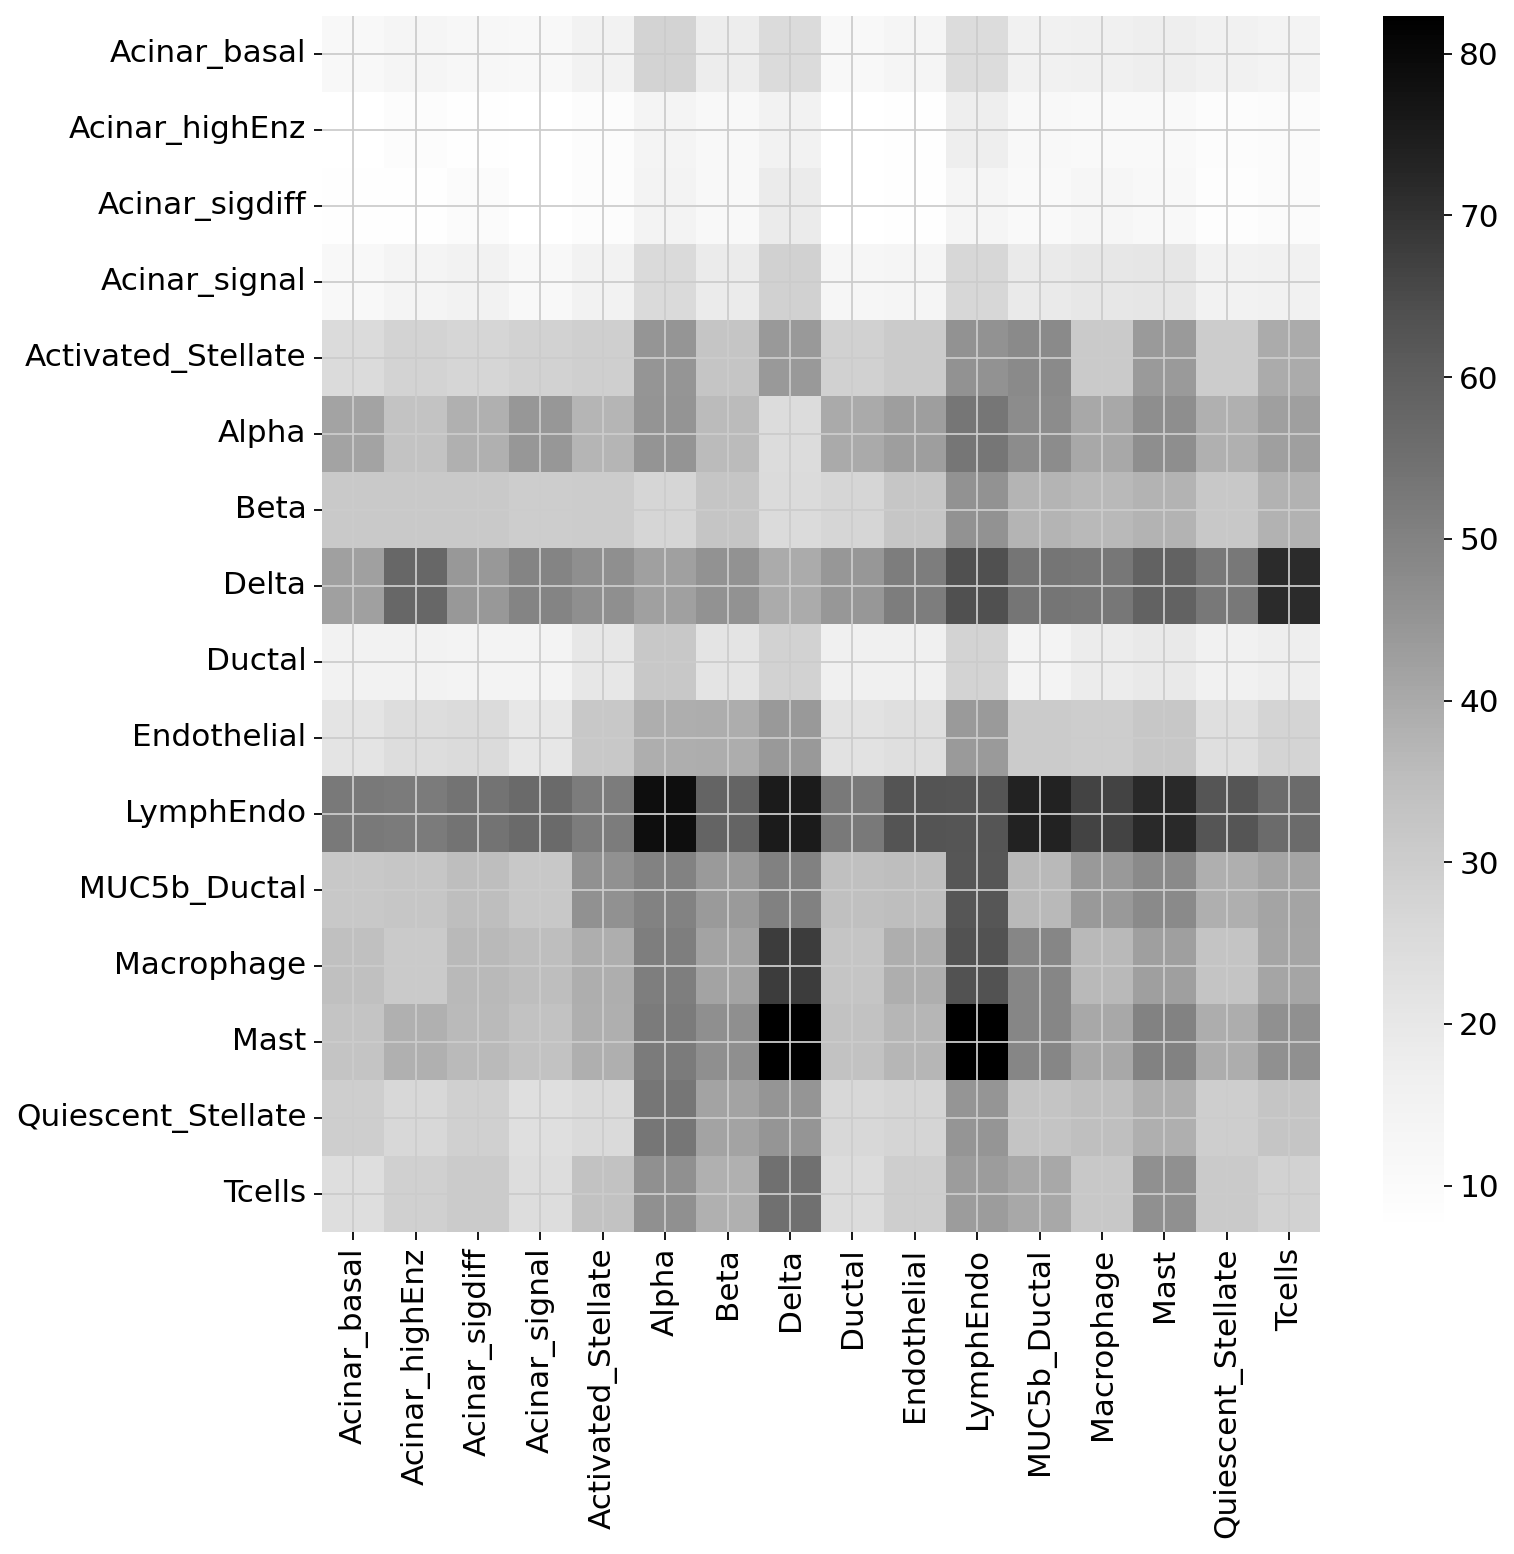

In [50]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_int_10,cmap="Greys")

<Axes: >

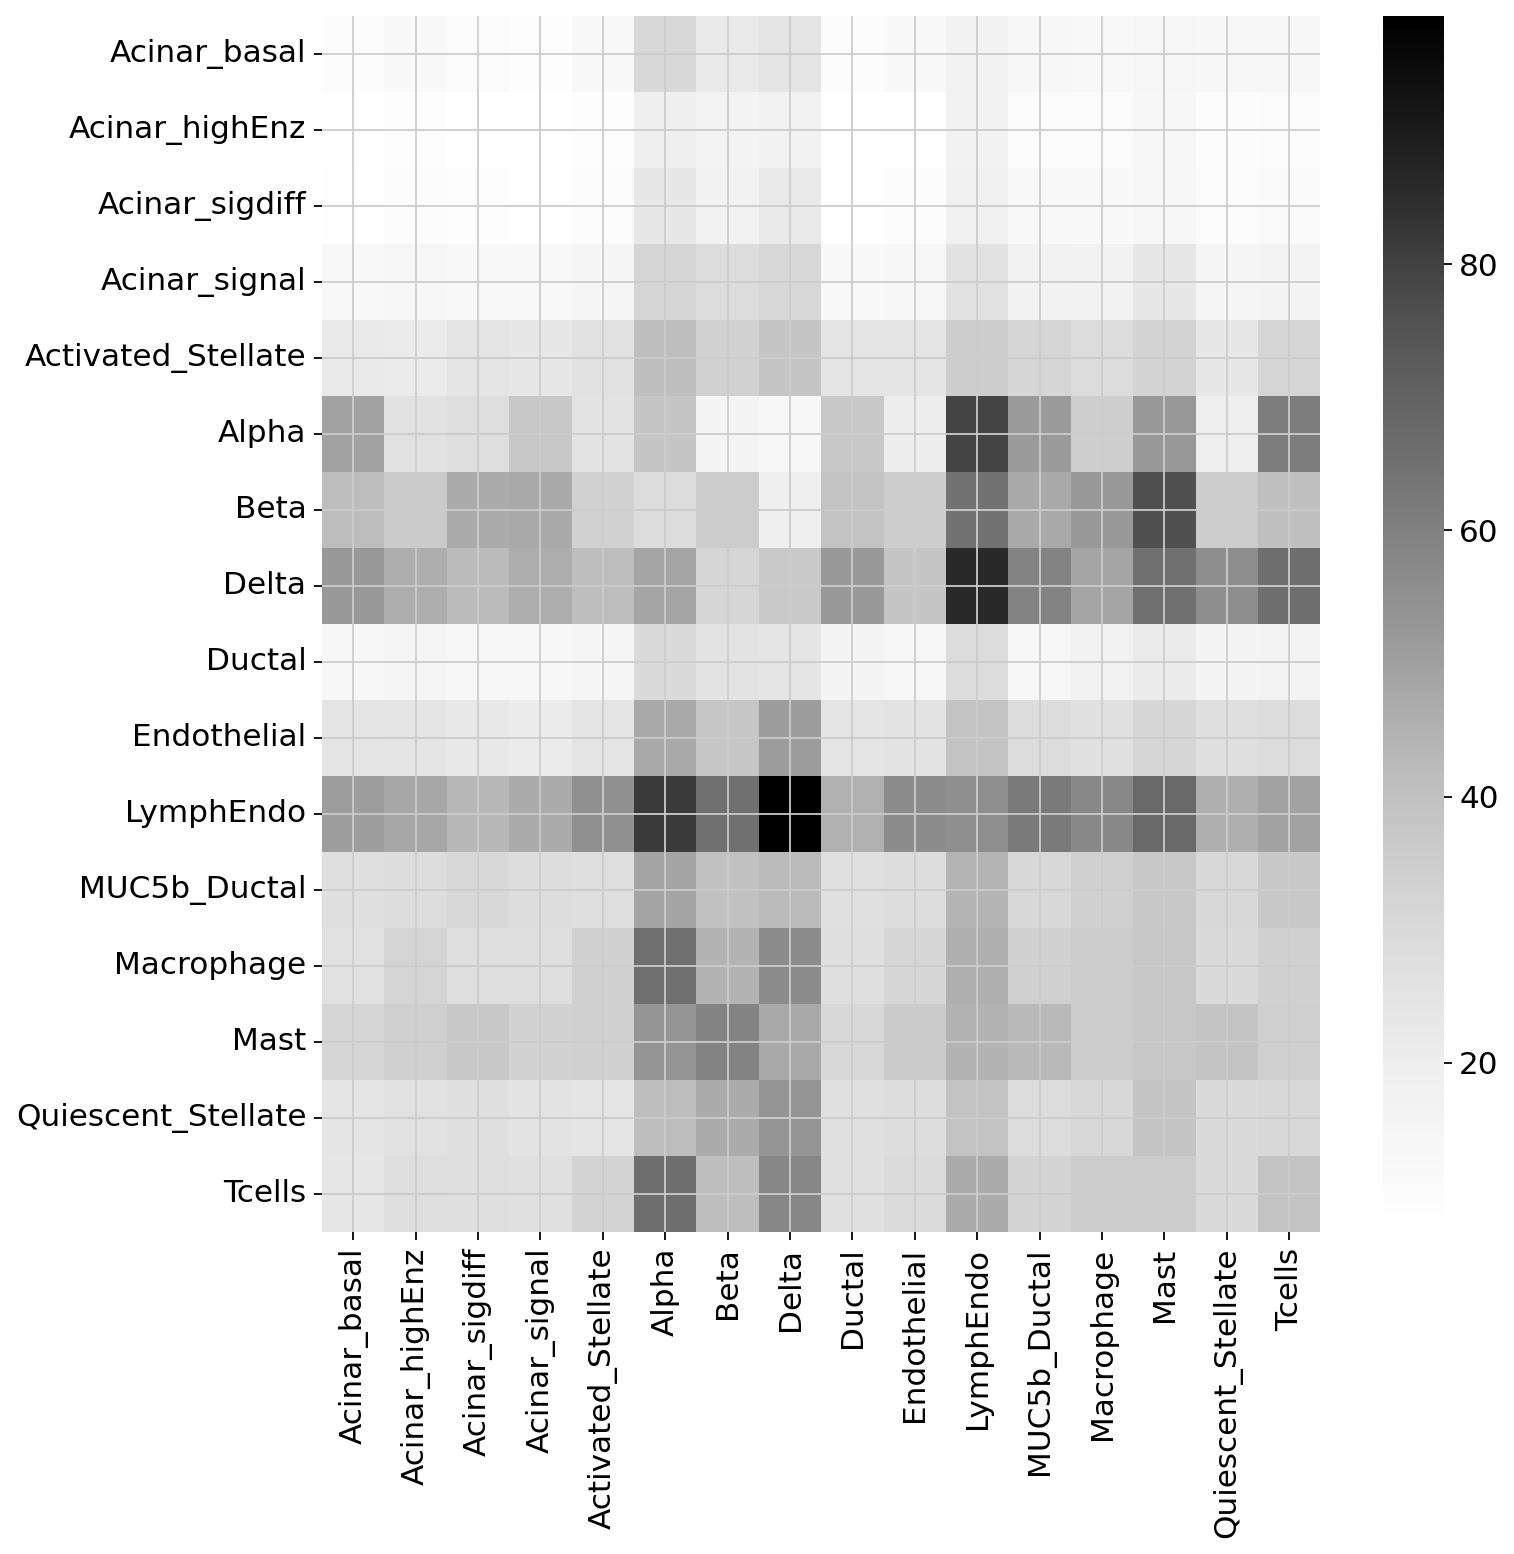

In [51]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_int_12,cmap="Greys")

In [56]:
interactions = [
    #'index_Endocrine_Exocrine:neighbor_Endocrine_Exocrine',
    'index_LymphEndo:neighbor_Delta'
]

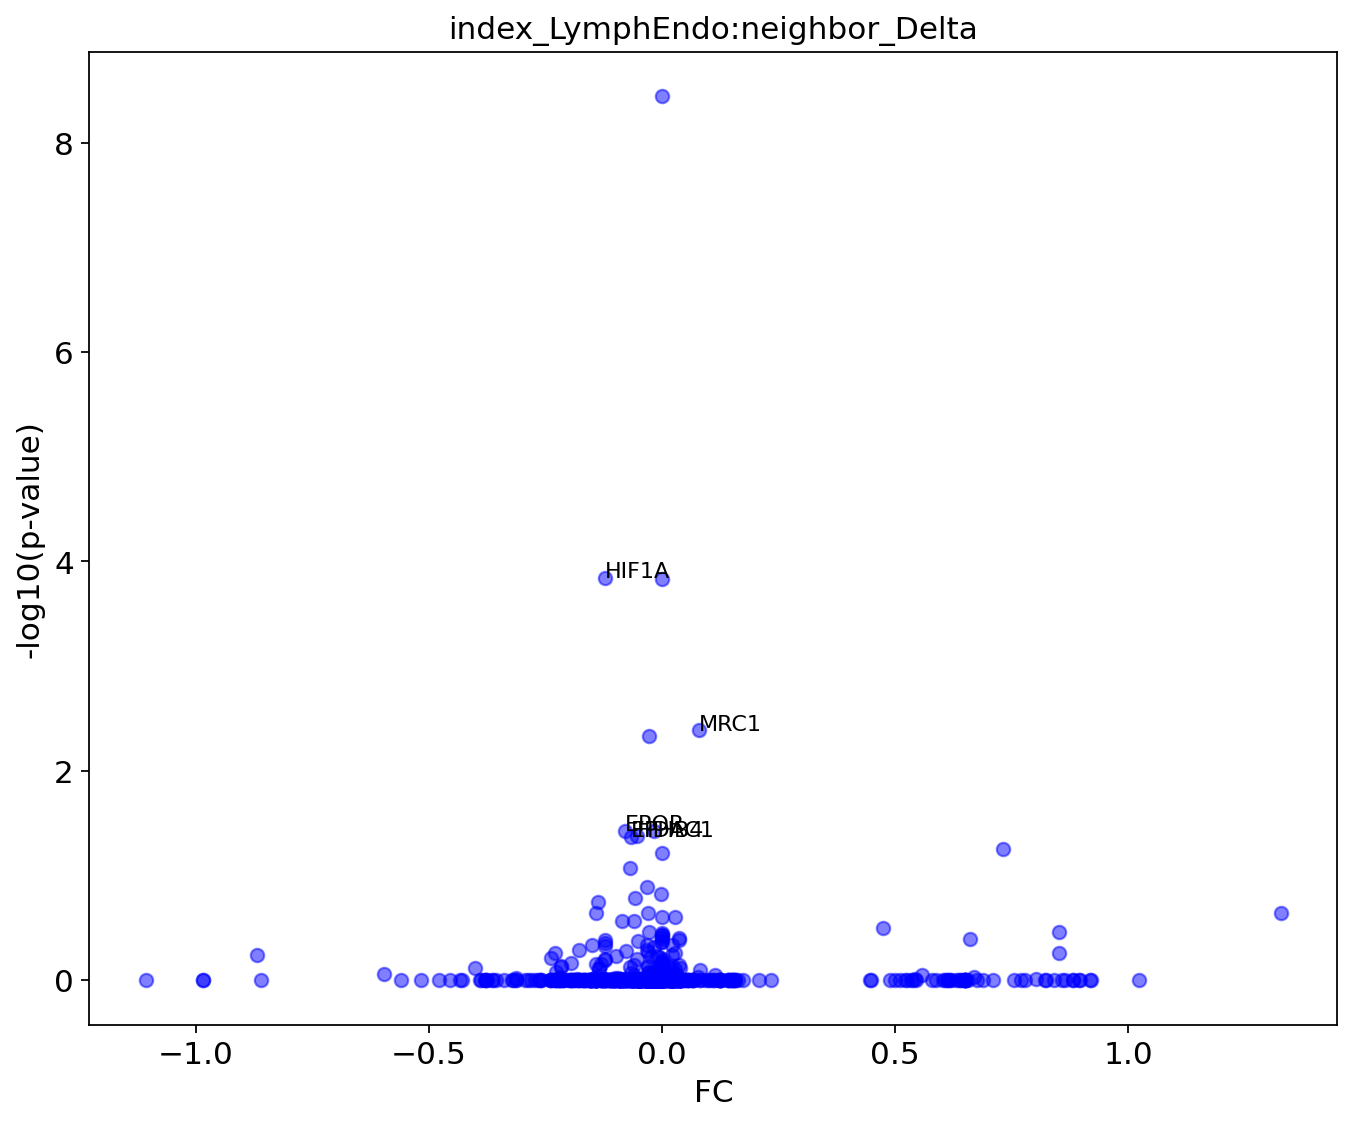

In [57]:
adata = adata_12.copy()
for c in interactions:
    data_df = {
        'log2FoldChange' : adata.varm['ncem_params'][c],
        'padj' : adata.varm['ncem_fdr_pvals'][c],
        'symbol' : np.array(adata.varm['ncem_fdr_pvals'].index)
    }
    
    df = pd.DataFrame(data_df)
    
    df['-log10(p_value)'] = -np.log10(df['padj'])
    

    plt.figure(figsize=(10, 8))
    plt.scatter(df['log2FoldChange'], df['-log10(p_value)'], color='blue', alpha=0.5)
    
    # Label the most significant points
    threshold_logFC = 0.05  # Adjust as needed
    threshold_p_value = 0.05  # Adjust as needed
    significant_points = df[(abs(df['log2FoldChange']) >= threshold_logFC) & (df['padj'] <= threshold_p_value)]
    for i, point in significant_points.iterrows():
        plt.text(point['log2FoldChange'], point['-log10(p_value)'], point['symbol'], fontsize=10)
        #volcano(df)
        
    # Add labels and title
    plt.xlabel('FC')
    plt.ylabel('-log10(p-value)')
    plt.title(c)
    
    # Show plot
    plt.grid(False)
    plt.show()

In [58]:
df

log2FoldChange          padj    symbol  -log10(p_value)
AATK        6.881201e-01  1.000000e+00      AATK        -0.000000
ABL1       -2.728771e-02  1.000000e+00      ABL1        -0.000000
ABL2       -2.138729e-02  1.000000e+00      ABL2        -0.000000
ACE        -5.190118e-02  1.000000e+00       ACE        -0.000000
ACE2       -9.718925e-03  1.000000e+00      ACE2        -0.000000
...                  ...           ...       ...              ...
NegPrb19   -1.685282e-15  3.592082e-09  NegPrb19         8.444654
NegPrb20   -4.565701e-15  1.000000e+00  NegPrb20        -0.000000
NegPrb21   -5.731085e-16  1.000000e+00  NegPrb21        -0.000000
NegPrb22   -1.217506e-01  1.000000e+00  NegPrb22        -0.000000
NegPrb23    9.385227e-17  1.000000e+00  NegPrb23        -0.000000

[979 rows x 4 columns]

In [59]:
#significant_points = df[(abs(df['log2FoldChange']) >= threshold_logFC) & (df['padj'] <= threshold_p_value)]
sp = significant_points.dropna().sort_values('-log10(p_value)', ascending=False)
# Replace infinite values with NaN
sp.replace([np.inf, -np.inf], np.nan, inplace=True)
sp.dropna(inplace=True)
sp

log2FoldChange      padj symbol  -log10(p_value)
HIF1A       -0.121354  0.000143  HIF1A         3.844278
MRC1         0.080099  0.004101   MRC1         2.387146
EPOR        -0.078940  0.037139   EPOR         1.430169
HDAC1       -0.054422  0.041907  HDAC1         1.377715
EPHB4       -0.066943  0.042439  EPHB4         1.372232

In [ ]:
sc.pl.matrixplot(adata, sp['symbol'], 'CellTypes_max', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='Greys')